In [30]:
import os
import sys
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

##### Parse in the metadata tables

In [31]:
METADATA_PATH="/private/groups/migalab/jmmenend/PAN/CDR_realignment_analysis/pan_centromere_realignment.13101294.metadata.tsv"
METADATA = pd.read_csv(METADATA_PATH, sep="\t", header=0)

METADATA["percentage"] = METADATA["percentage"].str.replace("%", "").astype(float)
METADATA["chrom"] = METADATA["from_chrom"].str.split(".").str[1]
METADATA = METADATA.dropna(subset=["from_chrom", "to_chrom"])

Parse in an manipulate @Monika's centromere based chromosome transmission table

In [32]:
centromere_transmissions_path = "/private/groups/migalab/jmmenend/PAN/CDR_realignment_analysis/verkko_2.0_centromere_transmissions_chromosome_transmissions.csv"
centromere_transmissions = pd.read_csv(centromere_transmissions_path, sep=",", header=None)

two_generational_inheritances = (
    centromere_transmissions.iloc[1, 1:].dropna().tolist() +
    centromere_transmissions.iloc[2, 1:].dropna().tolist()
)

three_generational_inheritances = (
    centromere_transmissions.iloc[9, 1:].dropna().tolist() +
    centromere_transmissions.iloc[11, 1:].dropna().tolist() +
    centromere_transmissions.iloc[13, 1:].dropna().tolist()
)

PAN027_three_gen_chroms = [x for x in three_generational_inheritances if "PAN027" in x]
PAN027_two_gen_chroms = [
    x.replace("maternal", "__TMP__").replace("paternal", "maternal").replace("__TMP__", "paternal")
    for x in PAN027_three_gen_chroms
]

three_generational_inheritances = [x for x in three_generational_inheritances if "PAN027" not in x]
two_generational_inheritances = [x for x in two_generational_inheritances if x not in three_generational_inheritances]

### Work on Visualizations

##### Plot **metadata**, summarizing the alignment percentages per chromosome

In [33]:
def chrom_sort_key(chrom):
    chrom = chrom.replace("chr", "")
    try:
        return int(chrom)
    except ValueError:
        return 23 if chrom == "X" else 24 if chrom == "Y" else 25
        
chrom_order = sorted(METADATA['chrom'].unique(), key=chrom_sort_key)
chrom_grouped = METADATA.groupby('chrom')

percentages = [chrom_grouped.get_group(ch)['percentage'].values for ch in chrom_order]

In [34]:
def get_color(from_chrom, to_chrom):
    if from_chrom.split('.')[1] != to_chrom.split('.')[1]:
        return
    elif from_chrom == to_chrom:
        return 'red'
    elif (from_chrom in three_generational_inheritances) and (to_chrom in PAN027_three_gen_chroms):
        return 'limegreen'
    elif (from_chrom in two_generational_inheritances) and (to_chrom in PAN027_two_gen_chroms):
        return 'orangered'
    else:
        return 'gray'

In [35]:
colors = []
for chrom, group in chrom_grouped:
    chrom_colors = []
    for _, row in group.iterrows():
        from_chrom, to_chrom = row['from_chrom'], row['to_chrom']
        chrom_colors.append( get_color(from_chrom, to_chrom) )
    colors.append( chrom_colors )

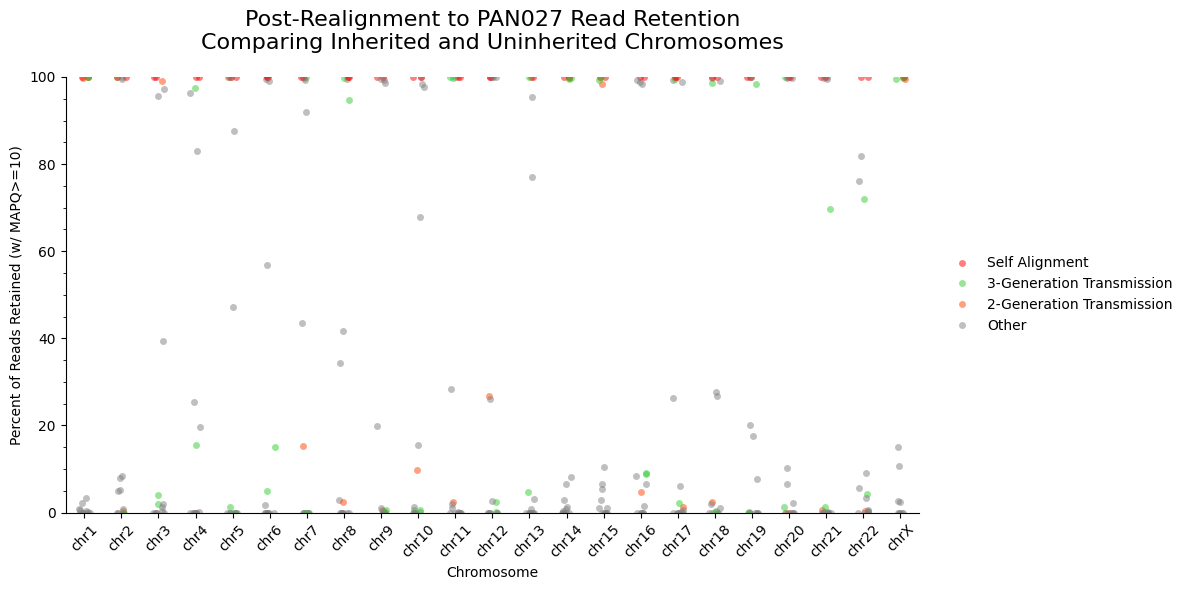

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))

for i, (values, color_list) in enumerate(zip(percentages, colors)):
    x_jitter = (np.random.rand(len(values)) - 0.5) * 0.3 + i

    for x, y, c in zip(x_jitter, values, color_list):
        ax.plot(x, y, 'o', markersize=5, alpha=0.5, color=c, markeredgewidth=0)

ax.set_xticks(range(len(chrom_order)))
ax.set_xticklabels(chrom_order, rotation=45)
ax.set_xlabel("Chromosome")
ax.set_xlim(-0.5, len(chrom_order) - 0.5)

ax.set_ylabel("Percent of Reads Retained (w/ MAPQ>=10)")
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.set_ylim(0, 100)

ax.set_title("Post-Realignment to PAN027 Read Retention\nComparing Inherited and Uninherited Chromosomes", fontsize=16, pad=20)

ax.spines[['top', 'right']].set_visible(False)

legend_handles = [
    Line2D([0], [0], marker='o', color='none', markerfacecolor='red', alpha=0.5,
           markersize=5, markeredgewidth=0, label='Self Alignment'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor='limegreen', alpha=0.5,
           markersize=5, markeredgewidth=0, label='3-Generation Transmission'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor='orangered', alpha=0.5,
           markersize=5, markeredgewidth=0, label='2-Generation Transmission'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor='gray', alpha=0.5,
           markersize=5, markeredgewidth=0, label='Other')
]
ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

plt.tight_layout()
plt.show()

##### Plot the same data, but not separated by chromosome

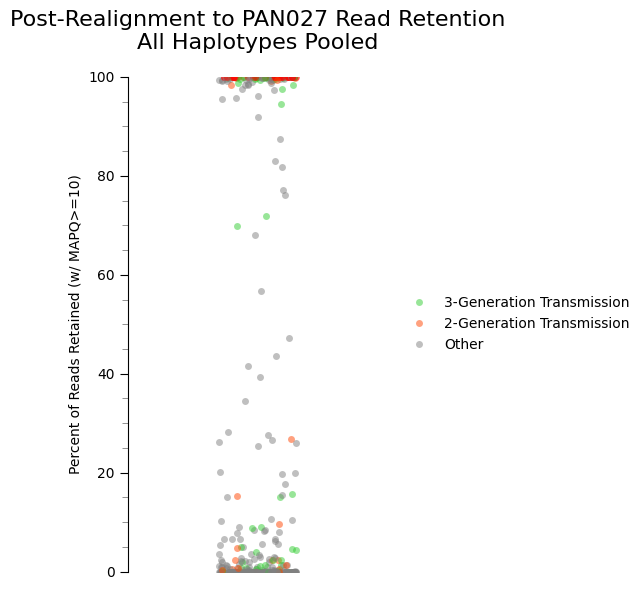

In [37]:
all_percentages = [v for sublist in percentages for v in sublist]
all_colors = [c for sublist in colors for c in sublist]
x_jitter = (np.random.rand(len(all_percentages)) - 0.5) * 0.6  # wider spread

fig, ax = plt.subplots(figsize=(6, 6))

for x, y, c in zip(x_jitter, all_percentages, all_colors):
    ax.plot(x, y, 'o', markersize=5, alpha=0.5, color=c, markeredgewidth=0)

ax.set_xlim(-1, 1)
ax.set_xticks([])  # hide x-axis ticks
ax.set_xlabel("")  # no label

ax.set_ylabel("Percent of Reads Retained (w/ MAPQ>=10)")
ax.set_ylim(0, 100)
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.tick_params(axis='y', which='minor', length=4, color='gray', direction='out')
ax.tick_params(axis='y', which='major', length=6, direction='out')

ax.set_title("Post-Realignment to PAN027 Read Retention\nAll Haplotypes Pooled", fontsize=16, pad=20)
ax.spines[['top', 'right', 'bottom']].set_visible(False)

legend_handles = [
    Line2D([0], [0], marker='o', color='none', markerfacecolor='limegreen', alpha=0.5,
           markersize=5, markeredgewidth=0, label='3-Generation Transmission'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor='orangered', alpha=0.5,
           markersize=5, markeredgewidth=0, label='2-Generation Transmission'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor='gray', alpha=0.5,
           markersize=5, markeredgewidth=0, label='Other')
]
ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

plt.tight_layout()
plt.show()

# Create Methylation/CDR Plots of Realigned Data

##### Read in the Data Needed to Make this Plot!

In [56]:
# read in the PAN027 data
PAN027_CENSAT_PATH = "/private/groups/migalab/mcechova/pedigree_assemblies/verkko2.0/assembly_release/figures/Figure2/PAN027.polished.diploid.cenSat.bed"
PAN027_CENSAT = pd.read_csv(PAN027_CENSAT_PATH, sep="\t", header=None, skiprows=1)
PAN027_ACTIVE_HOR = PAN027_CENSAT[PAN027_CENSAT[3].str.contains("active_hor", na=False)]

PAN027_HORHAP_PATH = "/private/groups/migalab/jmmenend/PAN/CDR_realignment_analysis/PAN027.horhap.bed"
PAN027_HORHAP = pd.read_csv(PAN027_HORHAP_PATH, sep="\t", header=None)
PAN027_HORHAP[0] = PAN027_HORHAP[0].str.replace('_', '.', regex=False) # correct _ in chromosome name...

PAN027_1DMDP_PATH = "/private/groups/migalab/jmmenend/PAN/CDR_realignment_analysis/PAN027_moddotplot_1d_strict.bed"
PAN027_1DMDP = pd.read_csv(PAN027_1DMDP_PATH, sep="\t", header=None)

PAN027_VCF_PATH = "/private/groups/migalab/mcechova/pedigree_assemblies/verkko2.0/assembly_release/figures/Figure2/polished.mutations.v1.vcf.gz"
PAN027_VCF = pd.read_csv(PAN027_VCF_PATH, sep="\t", header=None, comment="#")

PAN027_NONB_Z_PATH = "/private/groups/migalab/mcechova/pedigree_assemblies/verkko2.0/assembly_release/after_polishing_centromeres/nonB/PAN027/PAN027_pat_HiFi_element_final_pat.polished_Z.gff"
PAN027_NONB_Z = pd.read_csv(PAN027_NONB_Z_PATH, sep="\t", header=None, comment="#")

PAN027_NONB_APR_PATH = "/private/groups/migalab/mcechova/pedigree_assemblies/verkko2.0/assembly_release/after_polishing_centromeres/nonB/PAN027/PAN027_pat_HiFi_element_final_pat.polished_APR.gff"
PAN027_NONB_APR = pd.read_csv(PAN027_NONB_APR_PATH, sep="\t", header=None, comment="#")

## Three Generational Plotting

In [57]:
OUTDIR = "imgs_13101294"
os.makedirs(OUTDIR, exist_ok=True)

In [58]:
def find_cdr_paths(file_path):
    filename = os.path.basename(file_path)
    return (
            CHROM in filename
            and any(tag in filename for tag in ["PAN010", "PAN011", "PAN028"])
            and any(inherit_tag in filename for inherit_tag in three_generational_inheritances)
            and any(inherit_tag in filename for inherit_tag in PAN027_three_gen_chroms)
            and filename.endswith("centrodip.bed")
        )

def find_pileup_paths(file_path):
    filename = os.path.basename(file_path)
    return (
            CHROM in filename
            and any(tag in filename for tag in ["PAN010", "PAN011", "PAN028"])
            and any(inherit_tag in filename for inherit_tag in three_generational_inheritances)
            and any(inherit_tag in filename for inherit_tag in PAN027_three_gen_chroms)
            and filename.endswith("modkit.bed")
        )

#### Function for plotting three generational inheritance!

In [59]:
PAN027_HORHAP

0         1         2                 3    4  5  \
0      PAN027.chr10.maternal  39693620  39694978  S1C10H1L.1-8::C1  100  +   
1      PAN027.chr10.maternal  39696334  39697691  S1C10H1L.1-8::C4  100  +   
2      PAN027.chr10.maternal  39697691  39699049  S1C10H1L.1-8::C4  100  +   
3      PAN027.chr10.maternal  39699049  39700405  S1C10H1L.1-8::C4  100  +   
4      PAN027.chr10.maternal  39700405  39701762  S1C10H1L.1-8::C4  100  +   
...                      ...       ...       ...               ...  ... ..   
55280   PAN027.chrX.paternal  60538861  60540918  S3CXH1L.12-1::C4  100  +   
55281   PAN027.chrX.paternal  60540918  60542975  S3CXH1L.12-1::C4  100  +   
55282   PAN027.chrX.paternal  60542975  60545032  S3CXH1L.12-1::C4  100  +   
55283   PAN027.chrX.paternal  60545032  60547087  S3CXH1L.12-1::C4  100  +   
55284   PAN027.chrX.paternal  60547087  60549142  S3CXH1L.12-1::C4  100  +   

              6         7            8  
0      39693620  39694978   255,127,14  
1      39696334  39697691  148,103,189  
2      39697691  39699049  148,103,189  
3      39699049  39700405  148,103,189  
4      39700405  39701762  148,103,189  
...         ...       ...          ...  
55280  60538861  60540918  148,103,189  
55281  60540918  60542975  148,103,189  
55282  60542975  60545032  148,103,189  
55283  60545032  60547087  148,103,189  
55284  60547087  60549142  148,103,189  

[55285 rows x 9 columns]

In [63]:
def plot_three_gen_cdr_inheritance(CHROM):
    CHROM_NAME = [c for c in PAN027_three_gen_chroms if f"PAN027.{CHROM}." in c][0]
    print(f"plotting - {CHROM}/{CHROM_NAME} ...")

    def find_cdr_paths(file_path):
        filename = os.path.basename(file_path)
        return (
            CHROM in filename
            and any(tag in filename for tag in ["PAN010", "PAN011", "PAN028"])
            and any(inherit_tag in filename for inherit_tag in three_generational_inheritances)
            and any(inherit_tag in filename for inherit_tag in PAN027_three_gen_chroms)
            and filename.endswith("centrodip.bed")
        )

    def find_pileup_paths(file_path):
        filename = os.path.basename(file_path)
        return (
            CHROM in filename
            and any(tag in filename for tag in ["PAN010", "PAN011", "PAN028"])
            and any(inherit_tag in filename for inherit_tag in three_generational_inheritances)
            and any(inherit_tag in filename for inherit_tag in PAN027_three_gen_chroms)
            and filename.endswith("modkit.bed")
        )

    pattern = f'/private/groups/migalab/jmmenend/PAN/CDR_realignment_analysis/PAN_centromere_realignment_13101294/*.{CHROM}.*'
    all_matches = glob.glob(pattern)
    cdr_matches = sorted([f for f in all_matches if find_cdr_paths(f)])
    pileup_matches = sorted([f for f in all_matches if find_pileup_paths(f)])

    G1_CDR_PATH = next( (f for f in cdr_matches if "PAN010" in f or "PAN011" in f) )
    G1_CDR = pd.read_csv(G1_CDR_PATH, sep="\t", header=None)
    G1_PILEUP_PATH = next( (f for f in pileup_matches if "PAN010" in f or "PAN011" in f) )
    G1_PILEUP = pd.read_csv(G1_PILEUP_PATH, sep="\t", header=None)
    G1_PILEUP = G1_PILEUP[(G1_PILEUP[3] == "m") & (G1_PILEUP[4].astype(int) > 5)]
    G1_CDR_BASE = os.path.basename(G1_CDR_PATH)
    G1_CHROM = G1_CDR_BASE.split('_to_')[0]
    G1_SAMPLE = "Grandmother" if "PAN010" in G1_CHROM else "Grandfather"
    G1_COLOR = 'firebrick' if "PAN010" in G1_CHROM else "brown"

    PAN027_CDR_PATH = next( (f for f in all_matches if f.count(CHROM_NAME) == 2 and f.endswith("centrodip.bed")) )
    PAN027_CDR = pd.read_csv(PAN027_CDR_PATH, sep="\t", header=None)
    PAN027_PILEUP_PATH = next( (f for f in all_matches if f.count(CHROM_NAME) == 2 and f.endswith("modkit.bed")) )
    PAN027_PILEUP = pd.read_csv(PAN027_PILEUP_PATH, sep="\t", header=None)
    PAN027_PILEUP = PAN027_PILEUP[(PAN027_PILEUP[3] == "m") & (PAN027_PILEUP[4].astype(int) > 5)]

    G3_CDR_PATH = next( (f for f in cdr_matches if "PAN028" in f) )
    G3_CDR = pd.read_csv(G3_CDR_PATH, sep="\t", header=None)
    G3_PILEUP_PATH = next( (f for f in pileup_matches if "PAN028" in f ) )
    G3_PILEUP= pd.read_csv(G3_PILEUP_PATH, sep="\t", header=None)
    G3_PILEUP = G3_PILEUP[(G3_PILEUP[3] == "m") & (G3_PILEUP[4].astype(int) > 5)]
    G3_CDR_BASE = os.path.basename(G3_CDR_PATH)
    G3_CHROM = G3_CDR_BASE.split('_to_')[0]
    G3_SAMPLE = "Granddaughter"

    fig, ax = plt.subplots(figsize=(12, 4))

    active_alpha = PAN027_ACTIVE_HOR[
        (PAN027_ACTIVE_HOR[0] == CHROM_NAME)
    ]

    active_alpha_start = active_alpha[1].min()
    active_alpha_end = active_alpha[2].max()
    buffer_size = 100_000
    xtick_interval = 1_000_000
    colors = [G1_COLOR, 'lightsalmon', '#ebb400']
    # G3 color was too light trying a few new ones...
    # goldenrod, darkgoldenrod, orange, darkkhaki, y ,#8B4513, #FF8C00, #CD853F, #ebb400

    ax.set_xticks(np.arange(active_alpha_start, active_alpha_end+xtick_interval, xtick_interval))
    ax.set_xlim(active_alpha_start-buffer_size, active_alpha_end+buffer_size)

    # === Plot Variants ===
    y = 0
    variants = PAN027_VCF[
        (PAN027_VCF[0] == CHROM_NAME) &
        (PAN027_VCF[1] <= active_alpha_end + buffer_size) & 
        (PAN027_VCF[1] >= active_alpha_start - buffer_size)
    ]
    for _, row in variants.iterrows():
        x = row[1]
        r_len, q_len = len(row[3]), len(row[4])
        if r_len == q_len:
            # SNV
            color = "black"
            marker = '.'
        elif r_len < q_len:
            # deletion
            color = "black"
            marker = 'v'
        elif r_len > q_len:
            # insertion
            color = "black"
            marker = '^'

        ax.plot(x, [y], marker, linestyle='None', markersize=6, markeredgecolor='None', markerfacecolor=color, alpha=0.25)

    # === Plot HORHaps ===
    y += 0.1
    horhap = PAN027_HORHAP[
        (PAN027_HORHAP[0] == CHROM_NAME) &
        (PAN027_HORHAP[1] <= active_alpha_end + buffer_size) & 
        (PAN027_HORHAP[2] >= active_alpha_start - buffer_size)
    ]
    for _, row in horhap.iterrows():
        chrom = row[0]
        start = row[1]
        end = row[2]
        length = end - start
        color = [int(c)/255 for c in row[8].split(",")]  # RGB normalized

        rect = mpatches.Rectangle((start, y), length, 0.1, facecolor=color, edgecolor='None', alpha=1)
        ax.add_patch(rect)

    # === Plot moddotplot ===
    y += 0.15
    moddotplot = PAN027_1DMDP[
        (PAN027_1DMDP[0] == CHROM_NAME) &
        (PAN027_1DMDP[1] <= active_alpha_end + buffer_size) & 
        (PAN027_1DMDP[2] >= active_alpha_start - buffer_size)
    ]
    for _, row in moddotplot.iterrows():
        chrom = row[0]
        start = row[1]
        end = row[2]
        length = end - start
        color = [int(c)/255 for c in row[8].split(",")]  # RGB normalized

        rect = mpatches.Rectangle((start, y), length, 0.1, facecolor=color, edgecolor='None', alpha=1)
        ax.add_patch(rect)

    # === Plot CenSats Near Active Alpha ===
    y += 0.15
    censat = PAN027_CENSAT[
        (PAN027_CENSAT[0] == CHROM_NAME) &
        (PAN027_CENSAT[1] <= active_alpha_end + buffer_size) & 
        (PAN027_CENSAT[2] >= active_alpha_start - buffer_size)
    ]
    for _, row in censat.iterrows():
        chrom = row[0]
        start = row[1]
        end = row[2]
        length = end - start
        color = [int(c)/255 for c in row[8].split(",")]

        rect = mpatches.Rectangle((start, y), length, 0.1, facecolor=color, edgecolor='None', alpha=1)
        ax.add_patch(rect)

    # === Plot Methylation in windows
    y += 0.15
    window_size = 5_000
    pileups = [G1_PILEUP, PAN027_PILEUP, G3_PILEUP]
    y_range = 0.2
    ax.axhline(y=y, lw=0.5, ls=':', color='grey')
    ax.axhline(y=y+y_range, lw=0.5, ls=':', color='grey')

    bin_edges = np.arange(active_alpha_start, active_alpha_end + window_size, window_size)
    bin_centers = bin_edges[:-1] + window_size // 2

    for pileup_data, color in zip(pileups, colors):

        positions = pileup_data[1].astype(int)

        try:
            methylation = pileup_data[10].astype(float) / 100
        except KeyError:
            methylation = pileup_data[3].astype(float)

        line_x, line_y = [], []

        for i in range(len(bin_edges) - 1):
            bin_start = bin_edges[i]
            bin_end = bin_edges[i + 1]
            in_bin = (positions >= bin_start) & (positions < bin_end)
            if not np.any(in_bin):
                continue

            mean_meth = methylation[in_bin].mean()
            y_vals = y + (mean_meth) * y_range
            x_vals = bin_centers[i]

            line_x.append(x_vals)
            line_y.append(y_vals)

        ax.plot(line_x, line_y, color=color, linewidth=1.2)

    # === Plot CDRs ===
    y += 0.25
    cdr_datas = [G1_CDR, PAN027_CDR, G3_CDR]
    y_values = [y+0.2, y+0.1, y]
    for cdr, y, color in zip(cdr_datas, y_values, colors):
        for _, row in cdr.iterrows():
            if row[3] != "CDR" and row[3] != "MDR":
                continue

            start = row[1]
            end = row[2]
            length = end - start

            rect = mpatches.Rectangle((start, y), length, 0.05, facecolor=color, edgecolor='None', alpha=1)
            ax.add_patch(rect)

    ax.set_xlabel("Position on " + CHROM_NAME)
    ax.set_ylim(-0.05, 1.15)
    ax.set_yticks([])

    ax.set_yticks([0, 0.15, 0.3, 0.45, 0.6, 0.75])
    ax.set_yticklabels(["De novo mutations", "HORhaps (k=6)", "Self-Identity Heatmap", "CenSat", "0", "100"])
    #ax.set_yticks([0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05])
    #ax.set_yticklabels(["De novo mutations", "A-Phased Repeats (APR)", "Z-DNA", "HorHaps", "Self-Identity Heatmap", "CenSat", "0", "100"])
    ax.spines[['top', 'right', 'left']].set_visible(False)
    ax.tick_params(axis='y', which='both', length=0)

    legend_handles = []
    cdr_labels = [f'{G1_SAMPLE} CDR', f'Mother CDR', f'{G3_SAMPLE} CDR']
    for color, label in zip(colors, cdr_labels):
        legend_handles.append(mpatches.Patch(color=color, label=label))
    cdr_legend = ax.legend(handles=legend_handles, loc='center left', frameon=False, bbox_to_anchor=(1, 0.825))
    fig.add_artist(cdr_legend)

    legend_handles = []
    pileup_labels = [f'{G1_SAMPLE} Methylation', 'Mother Methylation', f'{G3_SAMPLE} Methylation']
    for color, label in zip(colors, pileup_labels):
        legend_handles.append(plt.Line2D([], [], color=color, label=label, linewidth=1.2))
    pileup_legend = ax.legend(handles=legend_handles, loc='center left', frameon=False, bbox_to_anchor=(1, 0.575))
    fig.add_artist(pileup_legend)

    legend_handles = []
    for markers, labels in zip(['.', 'v', '^'], ["SNV", "Deletion", "Insertion"]):
        legend_handles.append(
            Line2D([0], [0], marker=markers, linestyle='None', markersize=6,
                markerfacecolor='black', markeredgecolor='none', label=labels, alpha=0.5)
        )
    vcf_legend = ax.legend(handles=legend_handles, loc='center left', frameon=False, bbox_to_anchor=(1, 0.05))
    fig.add_artist(vcf_legend)

    ax.set_title(f"Three Generational Inheritance of CDRs on {CHROM}", fontsize=16)

    fig.tight_layout()
    fig.savefig(f"{OUTDIR}/{CHROM}.three_gen.CDR_inheritance.png", dpi=600)
    plt.show()
    plt.close(fig)

### Run the Plotting for each chromosome:

plotting - chr1/PAN027.chr1.maternal ...


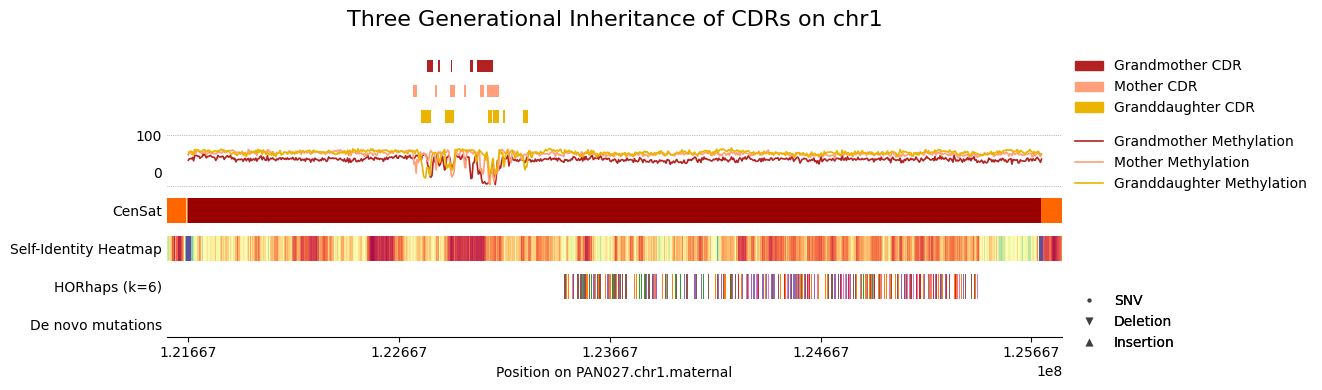

plotting - chr2/PAN027.chr2.paternal ...


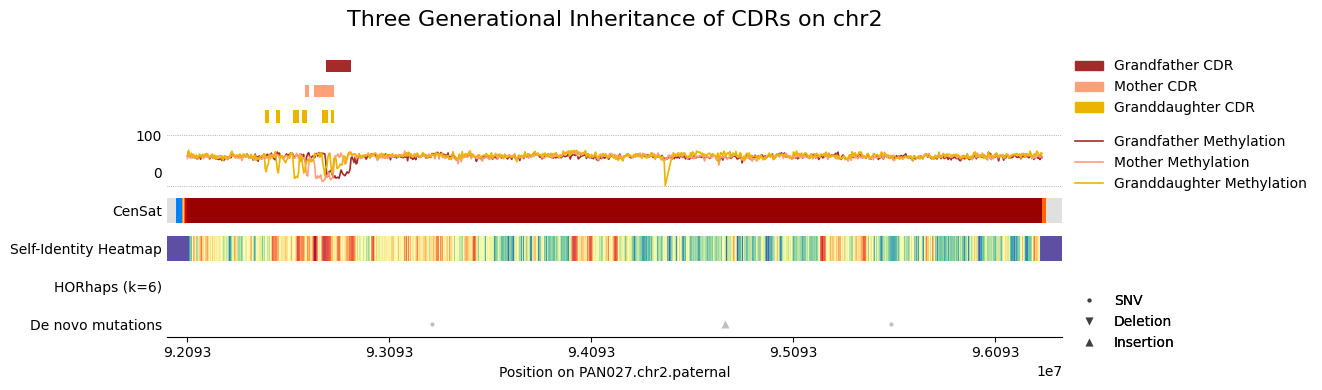

plotting - chr3/PAN027.chr3.paternal ...


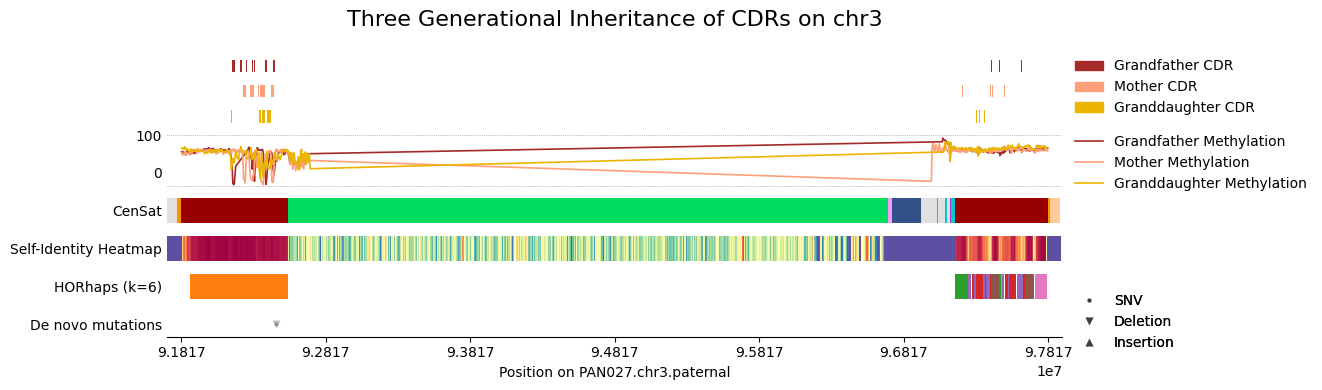

plotting - chr4/PAN027.chr4.paternal ...


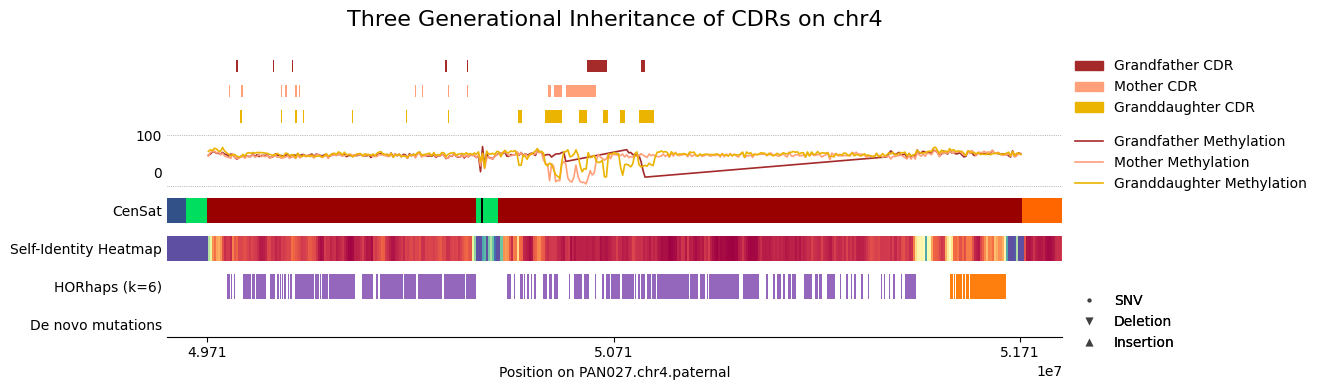

plotting - chr5/PAN027.chr5.paternal ...


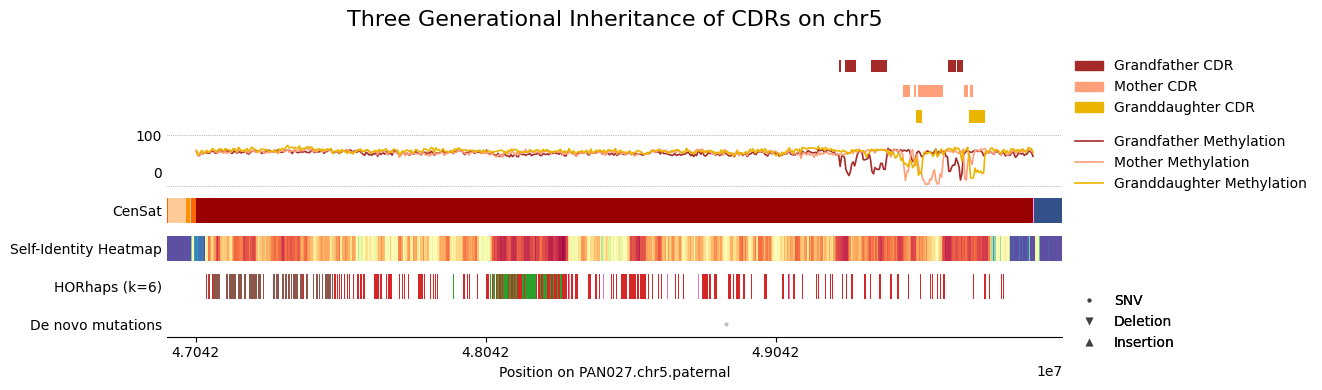

plotting - chr6/PAN027.chr6.maternal ...


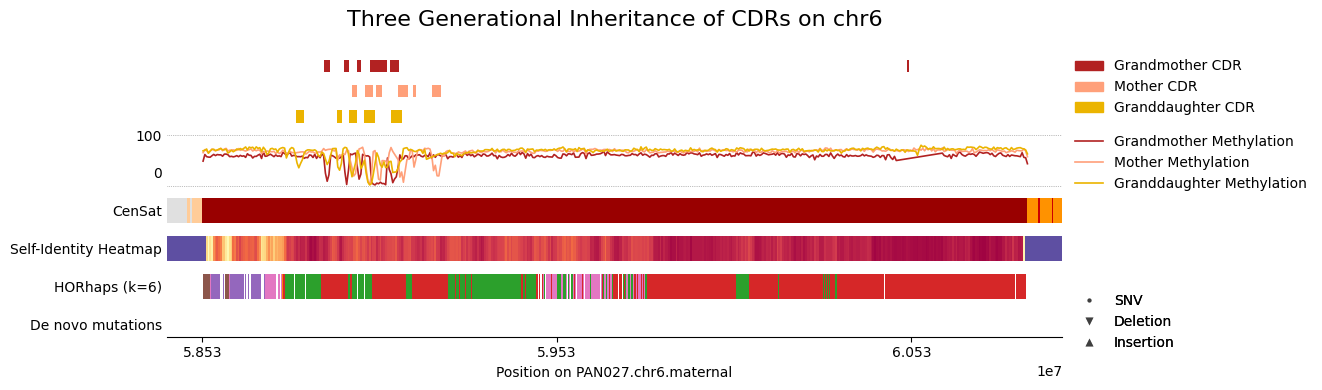

plotting - chr7/PAN027.chr7.maternal ...


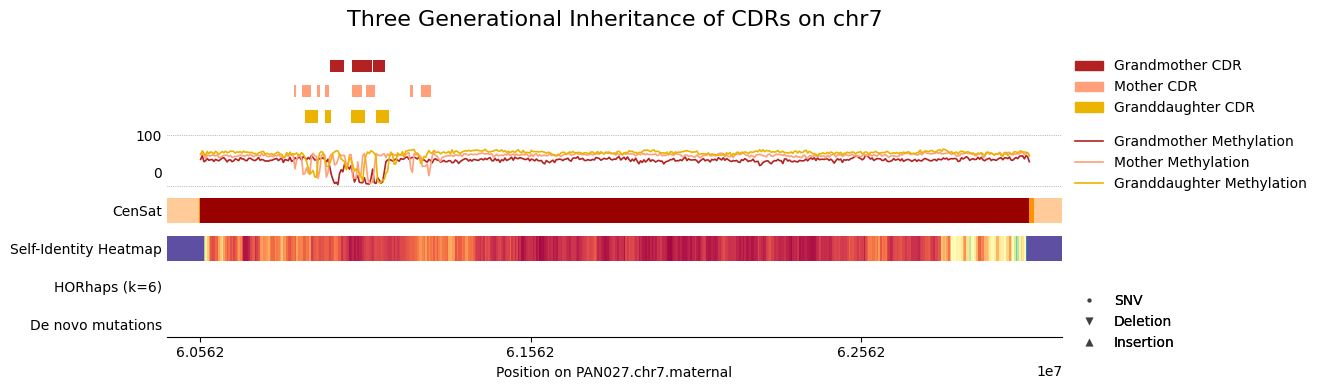

plotting - chr8/PAN027.chr8.paternal ...


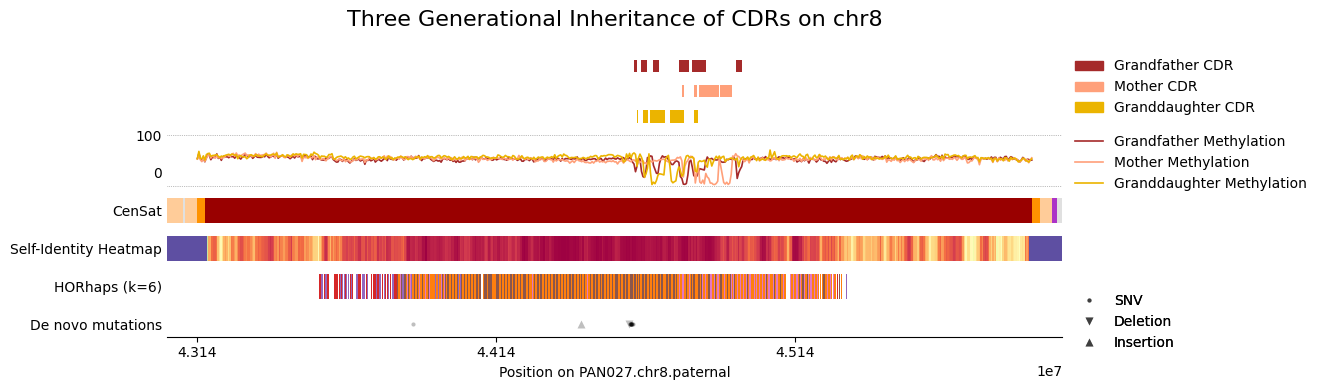

plotting - chr9/PAN027.chr9.paternal ...


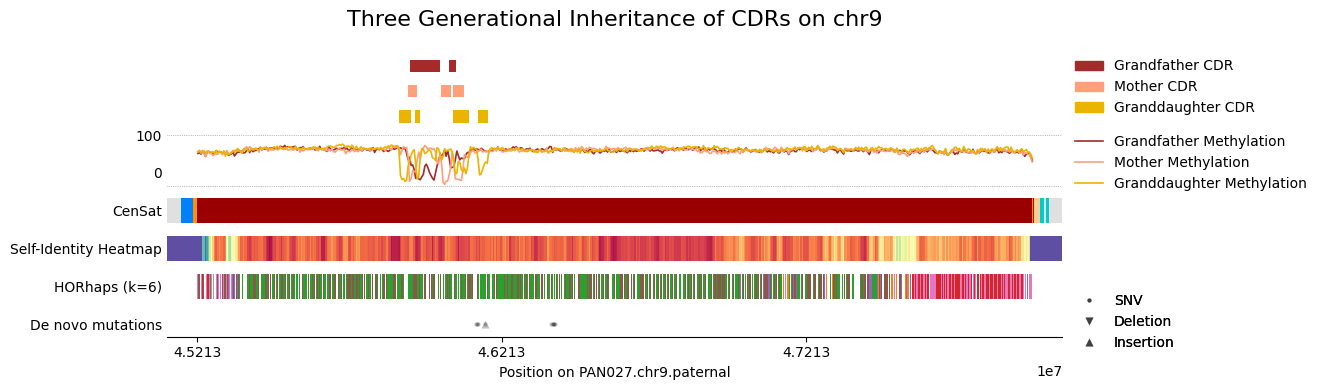

plotting - chr10/PAN027.chr10.maternal ...


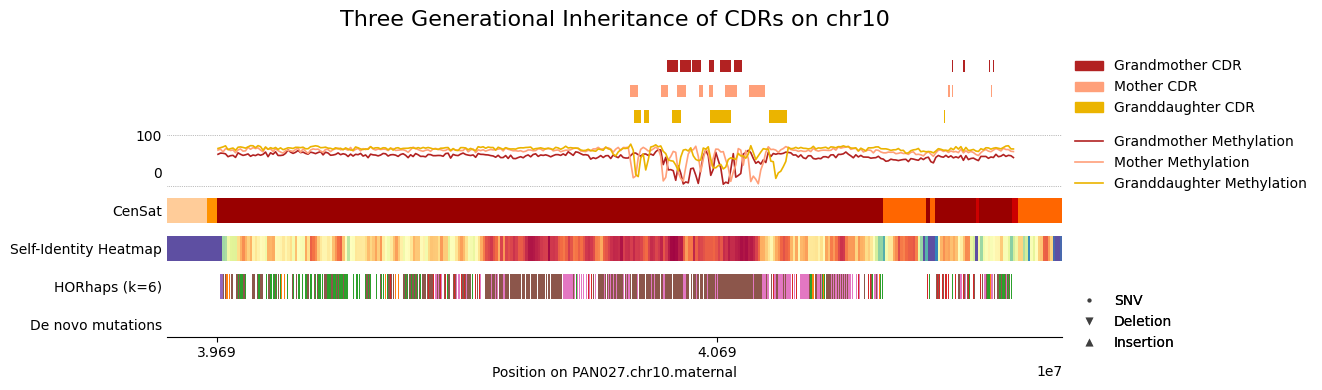

plotting - chr11/PAN027.chr11.paternal ...


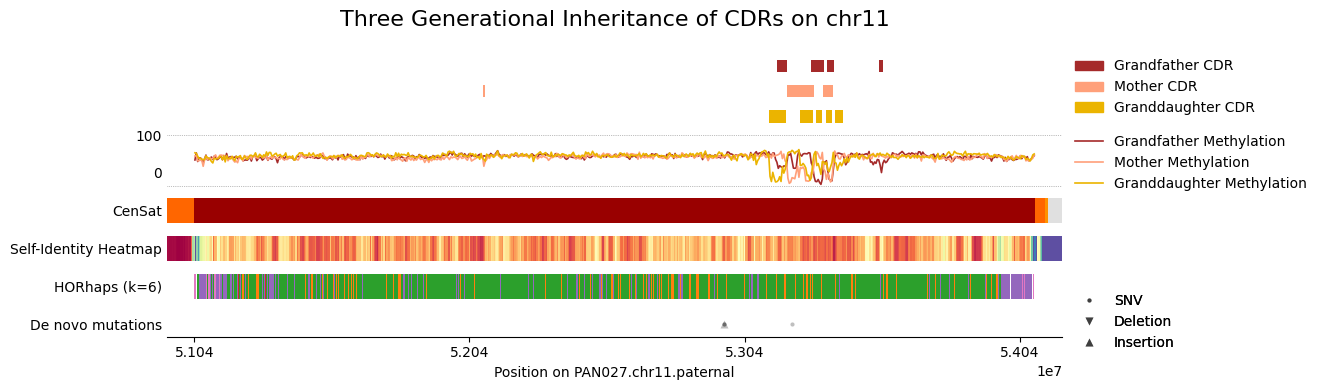

plotting - chr12/PAN027.chr12.paternal ...


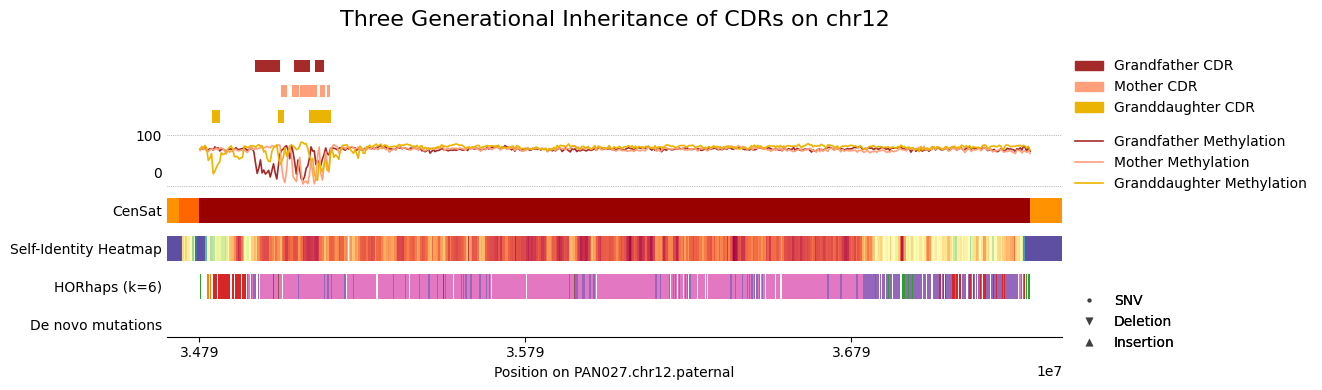

plotting - chr13/PAN027.chr13.maternal ...


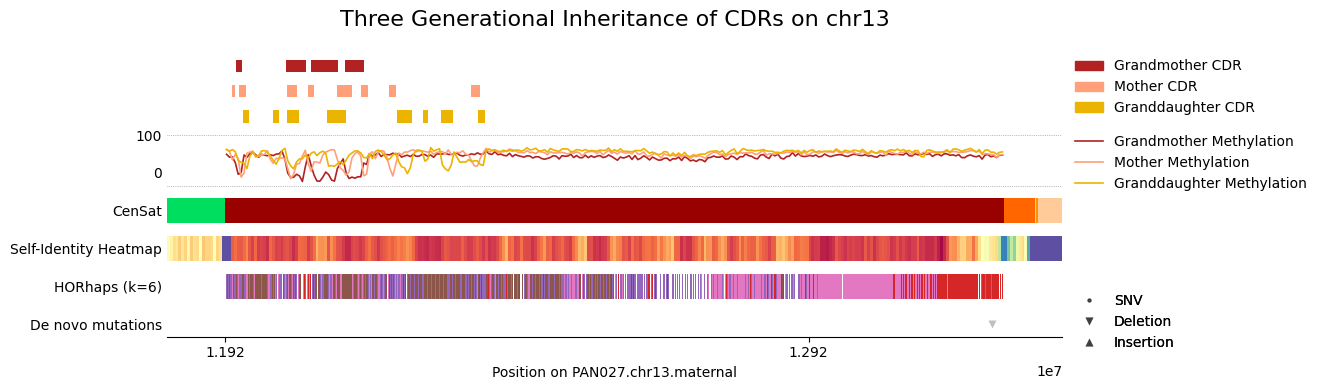

plotting - chr14/PAN027.chr14.paternal ...


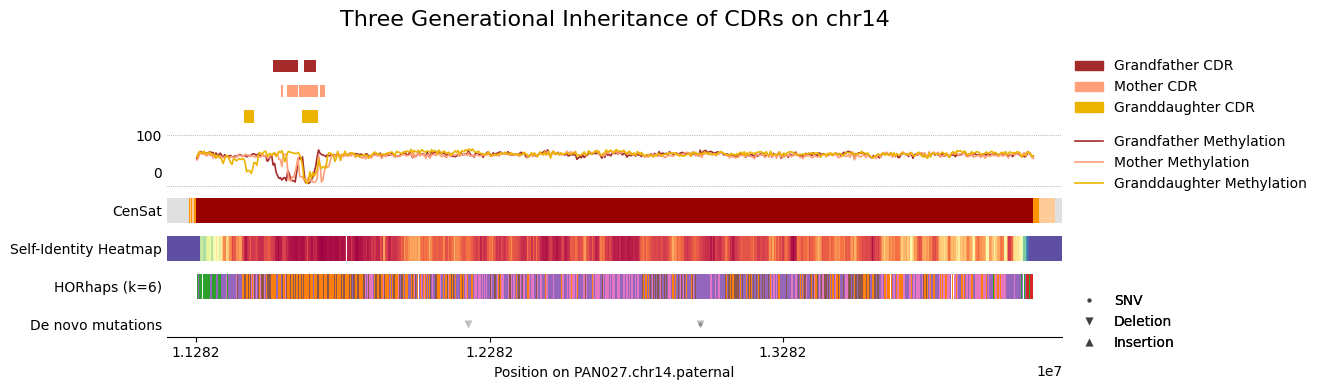

plotting - chr15/PAN027.chr15.paternal ...


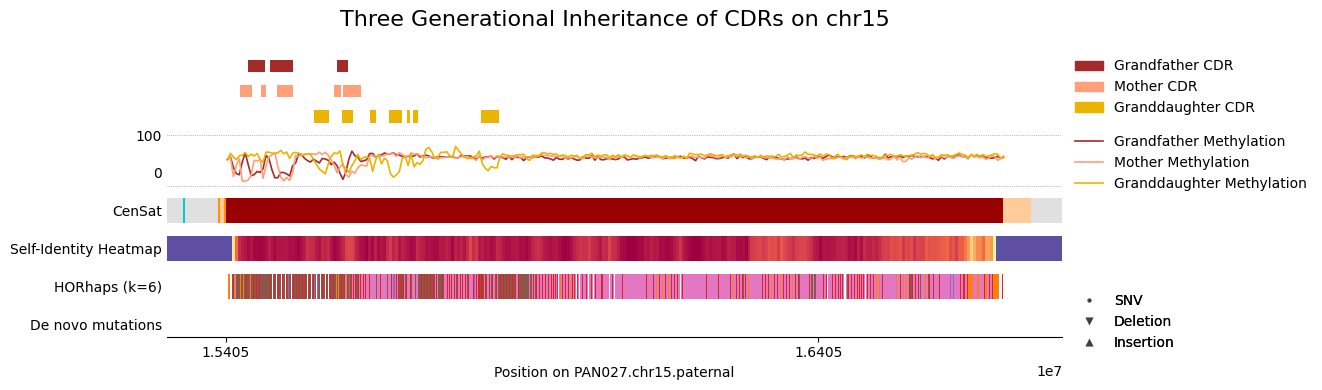

plotting - chr16/PAN027.chr16.paternal ...


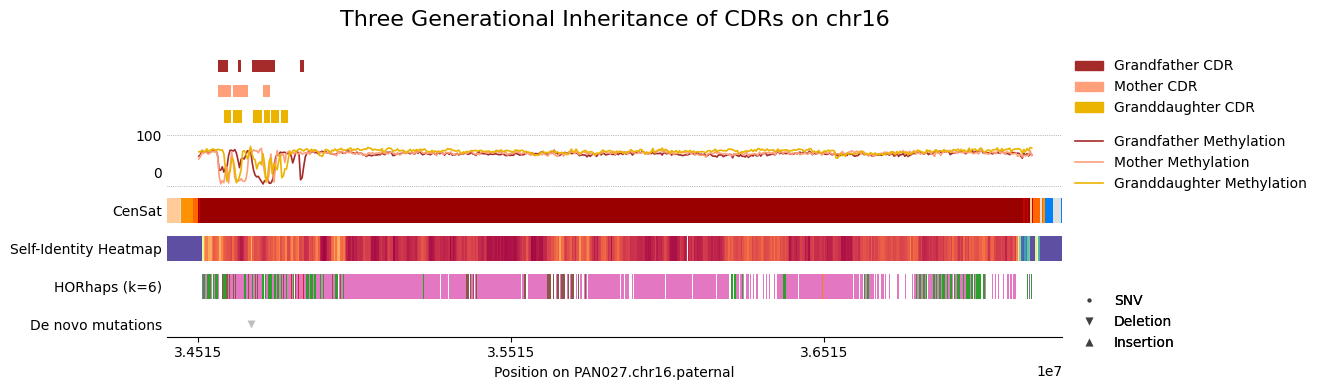

plotting - chr17/PAN027.chr17.maternal ...


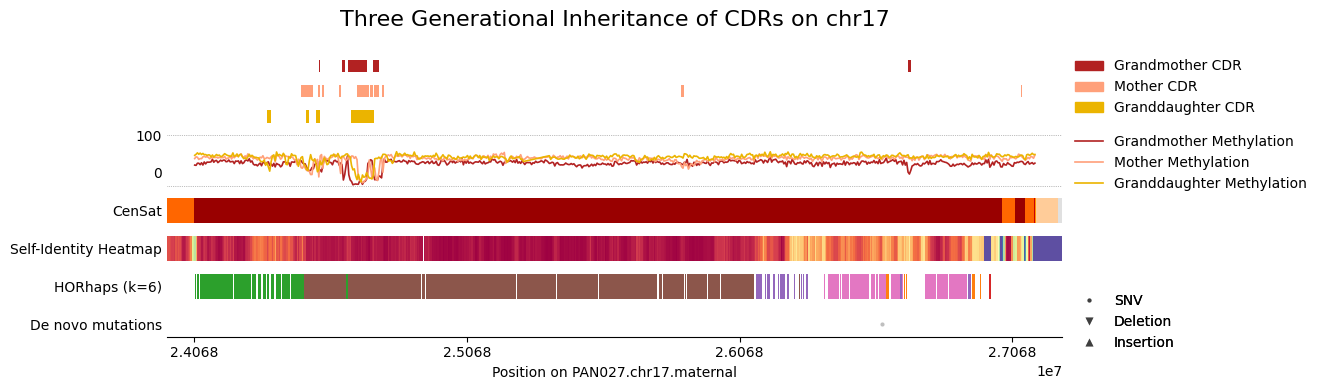

plotting - chr18/PAN027.chr18.maternal ...


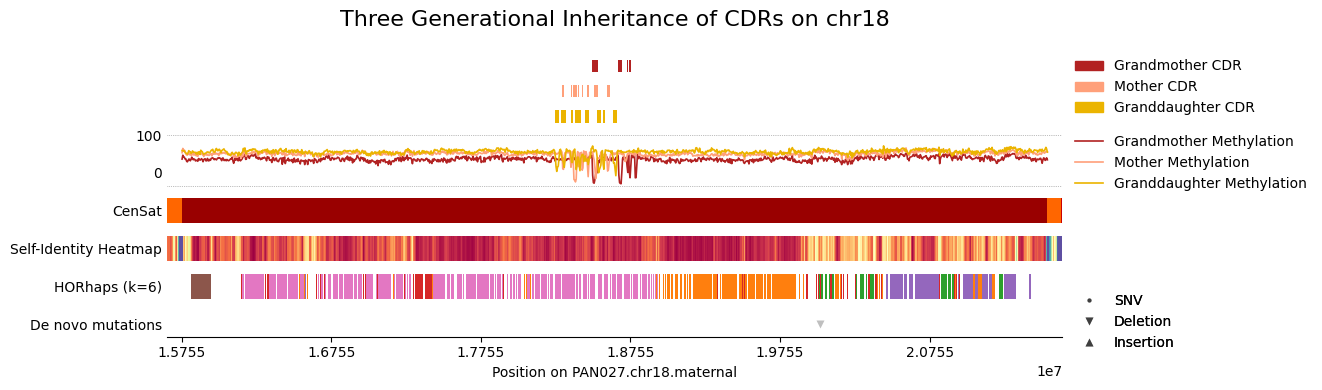

plotting - chr19/PAN027.chr19.paternal ...


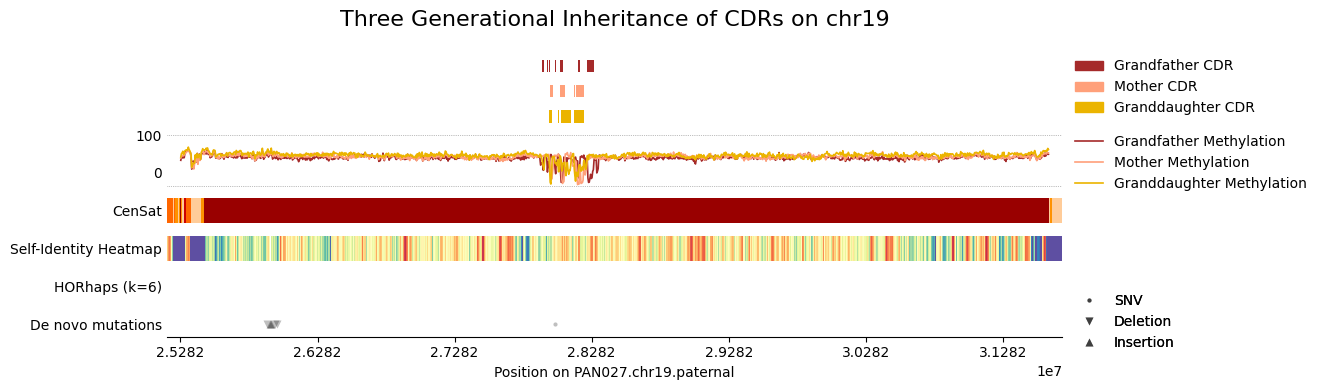

plotting - chr20/PAN027.chr20.maternal ...


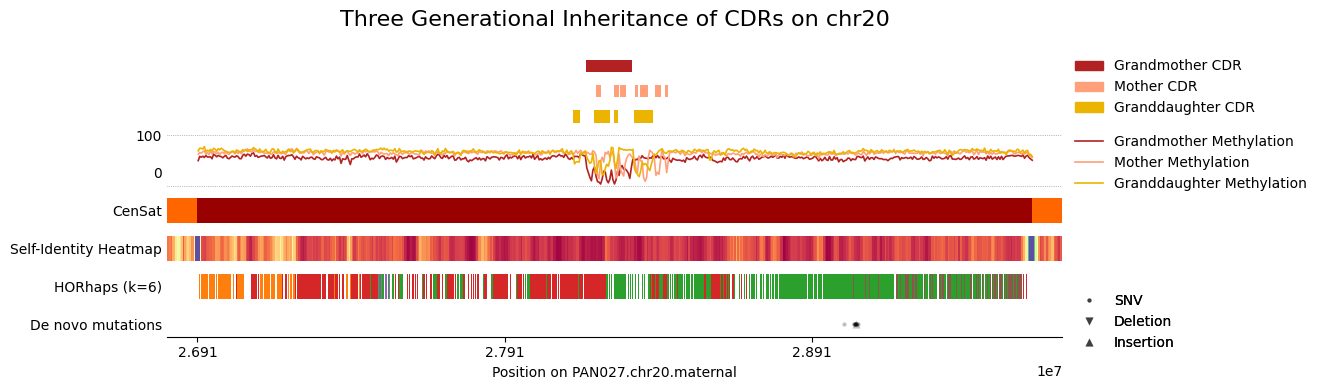

plotting - chr21/PAN027.chr21.paternal ...


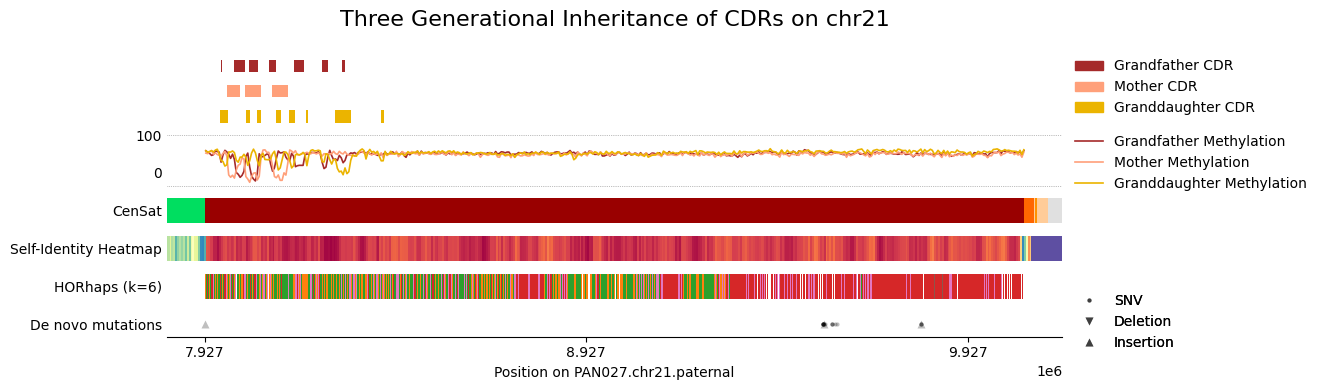

plotting - chr22/PAN027.chr22.paternal ...


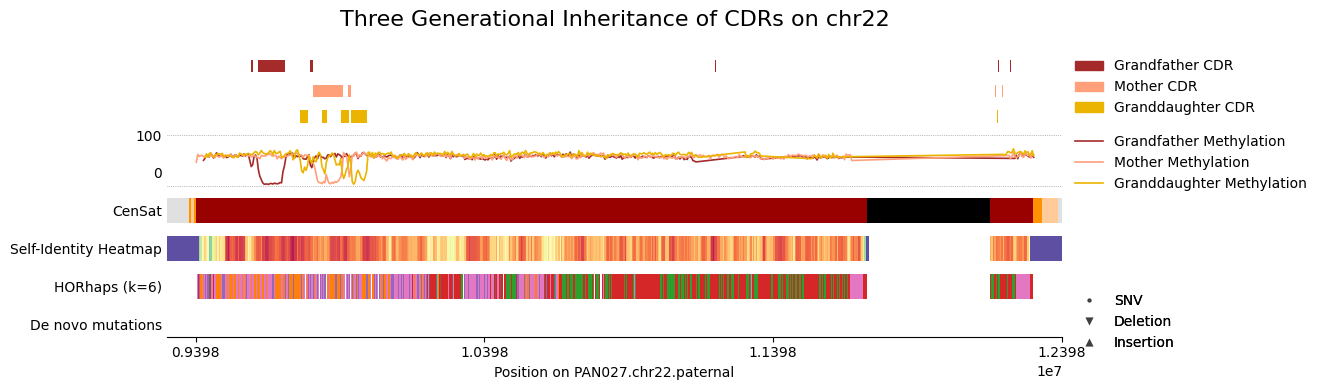

plotting - chrX/PAN027.chrX.maternal ...


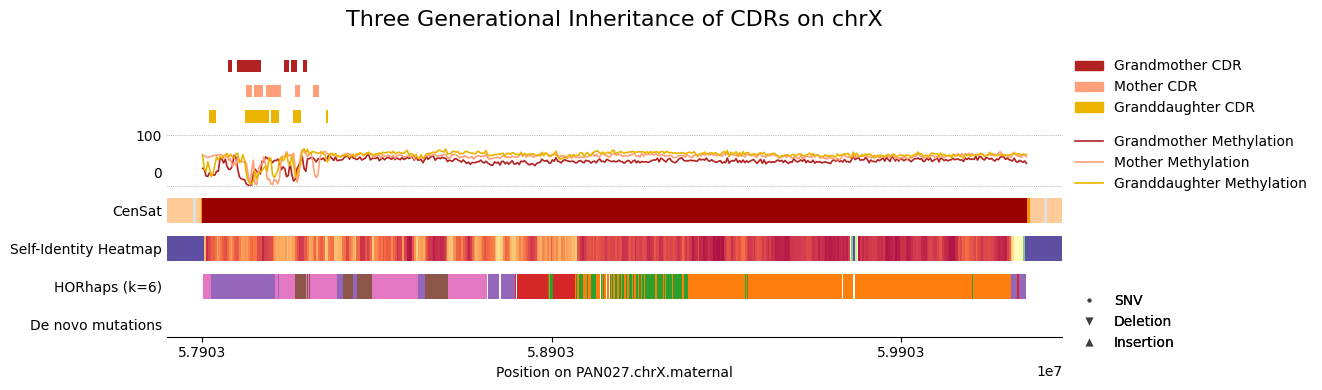

In [64]:
chroms = [f"chr{i}" for i in range(1, 23, 1)] + ["chrX"]

for c in chroms:
    plot_three_gen_cdr_inheritance( c )

## Two Generational Plotting

### Make a function for plotting two generational CDR inheritances

In [65]:
def plot_two_gen_cdr_inheritance(CHROM):
    CHROM_NAME = [c for c in PAN027_two_gen_chroms if f"PAN027.{CHROM}." in c][0]
    print(f"plotting PAN027 chrom - {CHROM}/{CHROM_NAME} ...")

    def find_cdr_paths(file_path):
        filename = os.path.basename(file_path)
        return (
            CHROM in filename
            and any(tag in filename for tag in ["PAN010", "PAN011", "PAN028"])
            and any(inherit_tag in filename for inherit_tag in two_generational_inheritances)
            and any(inherit_tag in filename for inherit_tag in PAN027_two_gen_chroms)
            and filename.endswith("centrodip.bed")
        )

    def find_pileup_paths(file_path):
        filename = os.path.basename(file_path)
        return (
            CHROM in filename
            and any(tag in filename for tag in ["PAN010", "PAN011", "PAN028"])
            and any(inherit_tag in filename for inherit_tag in two_generational_inheritances)
            and any(inherit_tag in filename for inherit_tag in PAN027_two_gen_chroms)
            and filename.endswith("modkit.bed")
        )

    pattern = f'/private/groups/migalab/jmmenend/PAN/CDR_realignment_analysis/PAN_centromere_realignment_13101294/*.{CHROM}.*'
    all_matches = glob.glob(pattern)
    cdr_matches = sorted([f for f in all_matches if find_cdr_paths(f)])
    pileup_matches = sorted([f for f in all_matches if find_pileup_paths(f)])

    G1_CDR_PATH = next( (f for f in cdr_matches if "PAN010" in f or "PAN011" in f) )
    G1_CDR = pd.read_csv(G1_CDR_PATH, sep="\t", header=None)
    G1_PILEUP_PATH = next( (f for f in pileup_matches if "PAN010" in f or "PAN011" in f) )
    G1_PILEUP = pd.read_csv(G1_PILEUP_PATH, sep="\t", header=None)
    G1_PILEUP = G1_PILEUP[(G1_PILEUP[3] == "m") & (G1_PILEUP[4].astype(int) > 5)]
    G1_CDR_BASE = os.path.basename(G1_CDR_PATH)
    G1_CHROM = G1_CDR_BASE.split('_to_')[0]
    G1_SAMPLE = "Grandmother" if "PAN010" in G1_CHROM else "Grandfather"
    G1_COLOR = 'firebrick' if "PAN010" in G1_CHROM else "brown"

    PAN027_CDR_PATH = next( (f for f in all_matches if f.count(CHROM_NAME) == 2 and f.endswith("centrodip.bed")) )
    PAN027_CDR = pd.read_csv(PAN027_CDR_PATH, sep="\t", header=None)
    PAN027_PILEUP_PATH = next( (f for f in all_matches if f.count(CHROM_NAME) == 2 and f.endswith("modkit.bed")) )
    PAN027_PILEUP = pd.read_csv(PAN027_PILEUP_PATH, sep="\t", header=None)
    PAN027_PILEUP = PAN027_PILEUP[(PAN027_PILEUP[3] == "m") & (PAN027_PILEUP[4].astype(int) > 5)]

    fig, ax = plt.subplots(figsize=(12, 4))

    active_alpha = PAN027_ACTIVE_HOR[
        (PAN027_ACTIVE_HOR[0] == CHROM_NAME)
    ]

    active_alpha_start = active_alpha[1].min()
    active_alpha_end = active_alpha[2].max()
    buffer_size = 100_000
    xtick_interval = 1_000_000
    colors = [G1_COLOR, 'lightsalmon']

    ax.set_xticks(np.arange(active_alpha_start, active_alpha_end+xtick_interval, xtick_interval))
    ax.set_xlim(active_alpha_start-buffer_size, active_alpha_end+buffer_size)

    # === Plot Variants ===
    y = 0
    variants = PAN027_VCF[
        (PAN027_VCF[0] == CHROM_NAME) &
        (PAN027_VCF[1] <= active_alpha_end + buffer_size) & 
        (PAN027_VCF[1] >= active_alpha_start - buffer_size)
    ]
    for _, row in variants.iterrows():
        x = row[1]
        r_len, q_len = len(row[3]), len(row[4])
        if r_len == q_len:
            # SNV
            color = "black"
            marker = '.'
        elif r_len < q_len:
            # deletion
            color = "black"
            marker = 'v'
        elif r_len > q_len:
            # insertion
            color = "black"
            marker = '^'

        ax.plot(x, [y], marker, linestyle='None', markersize=6, markeredgecolor='None', markerfacecolor=color, alpha=0.25)

    # === Plot HORHaps ===
    y += 0.1
    horhap = PAN027_HORHAP[
        (PAN027_HORHAP[0] == CHROM_NAME) &
        (PAN027_HORHAP[1] <= active_alpha_end + buffer_size) & 
        (PAN027_HORHAP[2] >= active_alpha_start - buffer_size)
    ]
    for _, row in horhap.iterrows():
        chrom = row[0]
        start = row[1]
        end = row[2]
        length = end - start
        color = [int(c)/255 for c in row[8].split(",")]  # RGB normalized

        rect = mpatches.Rectangle((start, y), length, 0.1, facecolor=color, edgecolor='None', alpha=1)
        ax.add_patch(rect)

    # === Plot moddotplot ===
    y += 0.15
    moddotplot = PAN027_1DMDP[
        (PAN027_1DMDP[0] == CHROM_NAME) &
        (PAN027_1DMDP[1] <= active_alpha_end + buffer_size) & 
        (PAN027_1DMDP[2] >= active_alpha_start - buffer_size)
    ]
    for _, row in moddotplot.iterrows():
        chrom = row[0]
        start = row[1]
        end = row[2]
        length = end - start
        color = [int(c)/255 for c in row[8].split(",")]  # RGB normalized

        rect = mpatches.Rectangle((start, y), length, 0.1, facecolor=color, edgecolor='None', alpha=1)
        ax.add_patch(rect)

    # === Plot CenSats Near Active Alpha ===
    y += 0.15
    censat = PAN027_CENSAT[
        (PAN027_CENSAT[0] == CHROM_NAME) &
        (PAN027_CENSAT[1] <= active_alpha_end + buffer_size) & 
        (PAN027_CENSAT[2] >= active_alpha_start - buffer_size)
    ]
    for _, row in censat.iterrows():
        chrom = row[0]
        start = row[1]
        end = row[2]
        length = end - start
        color = [int(c)/255 for c in row[8].split(",")]

        rect = mpatches.Rectangle((start, y), length, 0.1, facecolor=color, edgecolor='None', alpha=1)
        ax.add_patch(rect)

    # === Plot Methylation in windows
    y += 0.15
    window_size = 5_000
    pileups = [G1_PILEUP, PAN027_PILEUP]
    y_range = 0.2
    ax.axhline(y=y, lw=0.5, ls=':', color='grey')
    ax.axhline(y=y+y_range, lw=0.5, ls=':', color='grey')

    bin_edges = np.arange(active_alpha_start, active_alpha_end + window_size, window_size)
    bin_centers = bin_edges[:-1] + window_size // 2

    for pileup_data, color in zip(pileups, colors):

        positions = pileup_data[1].astype(int)

        try:
            methylation = pileup_data[10].astype(float) / 100
        except KeyError:
            methylation = pileup_data[3].astype(float)

        line_x, line_y = [], []

        for i in range(len(bin_edges) - 1):
            bin_start = bin_edges[i]
            bin_end = bin_edges[i + 1]
            in_bin = (positions >= bin_start) & (positions < bin_end)
            if not np.any(in_bin):
                continue

            mean_meth = methylation[in_bin].mean()
            y_vals = y + (mean_meth) * y_range
            x_vals = bin_centers[i]

            line_x.append(x_vals)
            line_y.append(y_vals)

        ax.plot(line_x, line_y, color=color, linewidth=1.2)

    # === Plot CDRs ===
    y += 0.25
    cdr_datas = [G1_CDR, PAN027_CDR]
    y_values = [y+0.2, y+0.1, y]
    for cdr, y, color in zip(cdr_datas, y_values, colors):
        for _, row in cdr.iterrows():
            if row[3] != "CDR" and row[3] != "MDR":
                continue

            start = row[1]
            end = row[2]
            length = end - start

            rect = mpatches.Rectangle((start, y), length, 0.05, facecolor=color, edgecolor='None', alpha=1)
            ax.add_patch(rect)

    ax.set_xlabel("Position on " + CHROM_NAME)
    ax.set_ylim(-0.05, 1.15)
    ax.set_yticks([])

    ax.set_yticks([0, 0.15, 0.3, 0.45, 0.6, 0.75])
    ax.set_yticklabels(["De novo mutations", "HorHaps", "Self-Identity Heatmap", "CenSat", "0", "100"])
    #ax.set_yticks([0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05])
    #ax.set_yticklabels(["De novo mutations", "A-Phased Repeats (APR)", "Z-DNA", "HorHaps", "Self-Identity Heatmap", "CenSat", "0", "100"])
    ax.spines[['top', 'right', 'left']].set_visible(False)
    ax.tick_params(axis='y', which='both', length=0)

    legend_handles = []
    cdr_labels = [f'{G1_SAMPLE} CDR', f'Mother CDR']
    for color, label in zip(colors, cdr_labels):
        legend_handles.append(mpatches.Patch(color=color, label=label))
    cdr_legend = ax.legend(handles=legend_handles, loc='center left', frameon=False, bbox_to_anchor=(1, 0.825))
    fig.add_artist(cdr_legend)

    legend_handles = []
    pileup_labels = [f'{G1_SAMPLE} Methylation', 'Mother Methylation']
    for color, label in zip(colors, pileup_labels):
        legend_handles.append(plt.Line2D([], [], color=color, label=label, linewidth=1.2))
    pileup_legend = ax.legend(handles=legend_handles, loc='center left', frameon=False, bbox_to_anchor=(1, 0.575))
    fig.add_artist(pileup_legend)

    legend_handles = []
    for markers, labels in zip(['.', 'v', '^'], ["SNV", "Deletion", "Insertion"]):
        legend_handles.append(
            Line2D([0], [0], marker=markers, linestyle='None', markersize=6,
                markerfacecolor='black', markeredgecolor='none', label=labels, alpha=0.5)
        )
    vcf_legend = ax.legend(handles=legend_handles, loc='center left', frameon=False, bbox_to_anchor=(1, 0.05))
    fig.add_artist(vcf_legend)

    ax.set_title(f"Two Generational Inheritance of CDRs on {CHROM}", fontsize=16)

    fig.tight_layout()
    fig.savefig(f"{OUTDIR}/{CHROM}.two_gen.CDR_inheritance.png", dpi=600)
    plt.show()
    plt.close(fig)

### Plot two generational inheritance events

plotting PAN027 chrom - chr1/PAN027.chr1.paternal ...


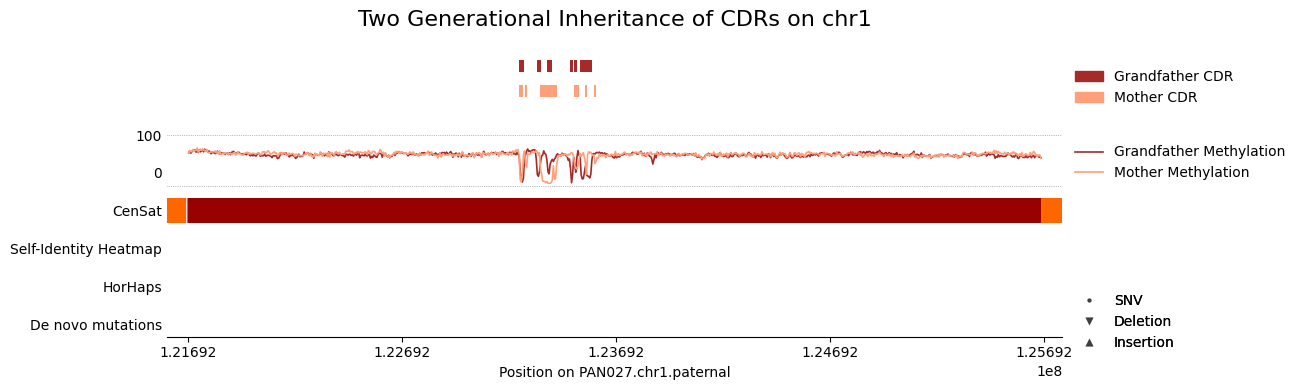

plotting PAN027 chrom - chr2/PAN027.chr2.maternal ...


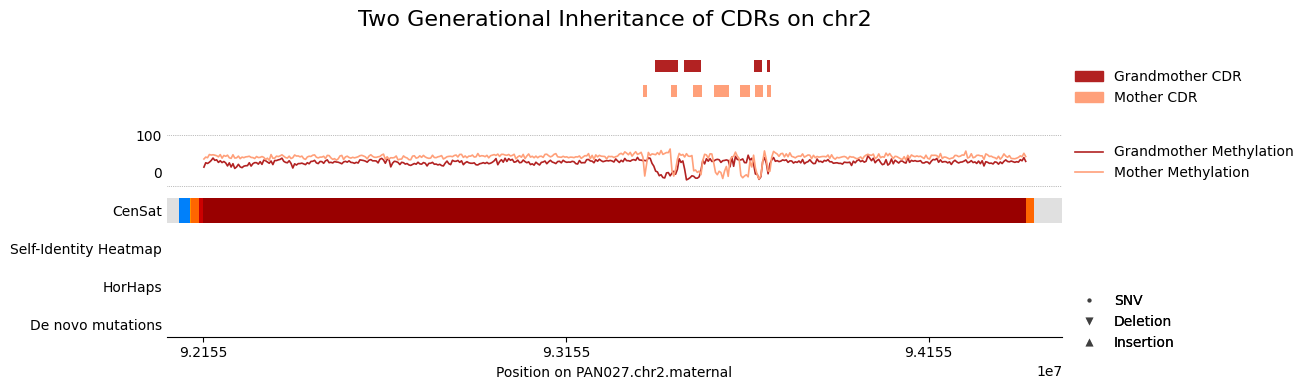

plotting PAN027 chrom - chr3/PAN027.chr3.maternal ...


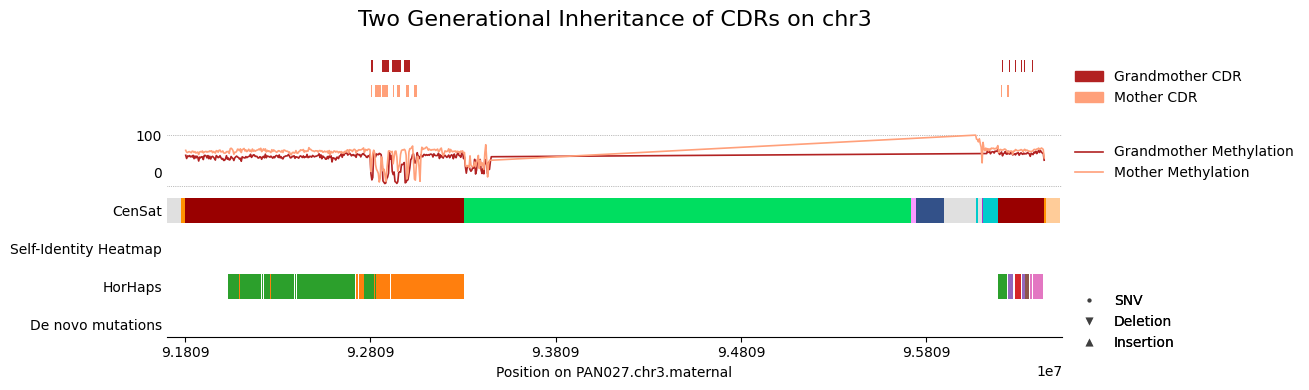

plotting PAN027 chrom - chr4/PAN027.chr4.maternal ...


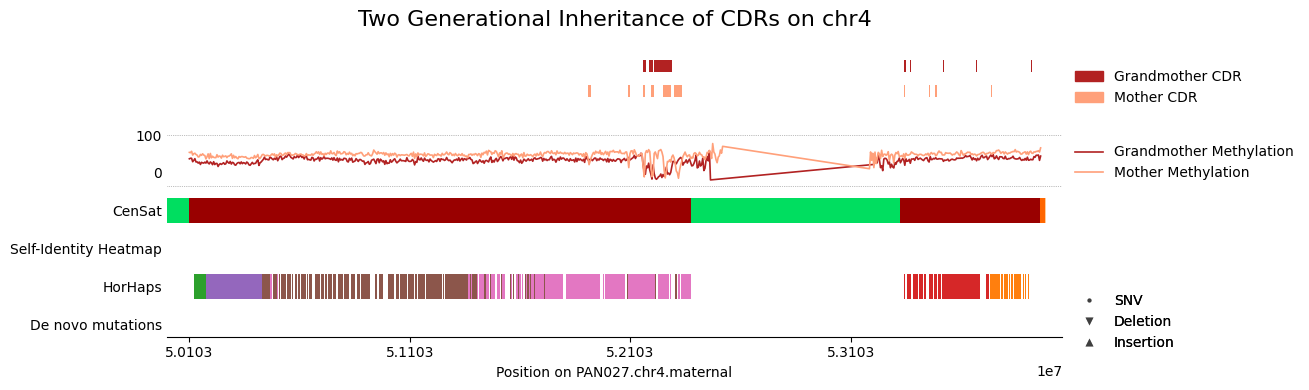

plotting PAN027 chrom - chr5/PAN027.chr5.maternal ...


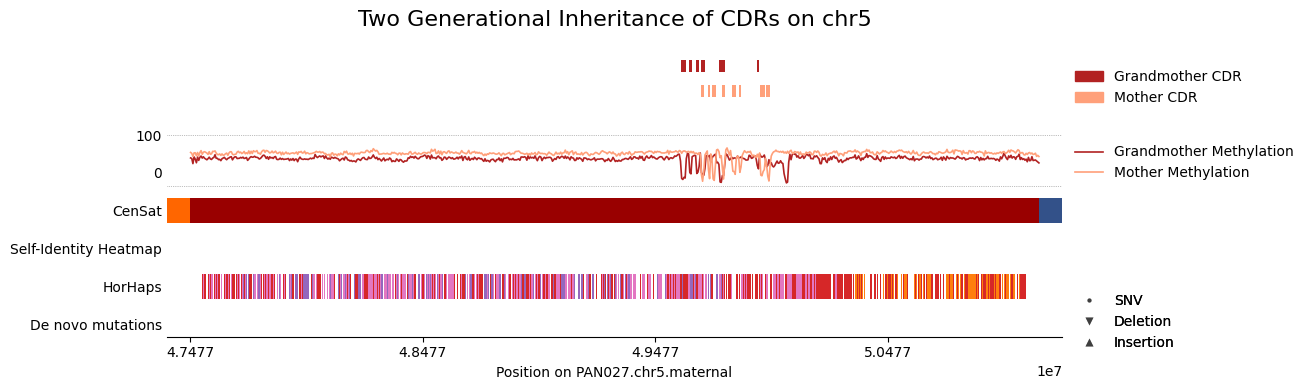

plotting PAN027 chrom - chr6/PAN027.chr6.paternal ...


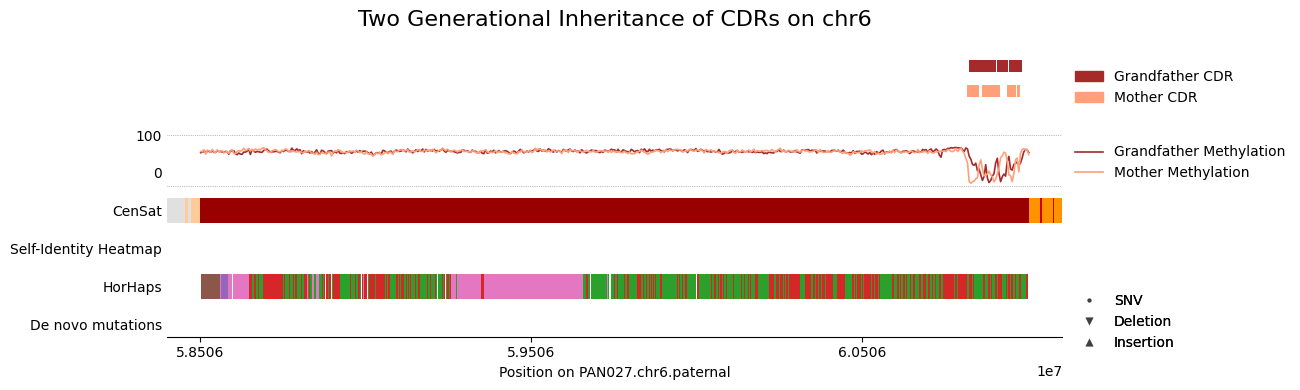

plotting PAN027 chrom - chr7/PAN027.chr7.paternal ...


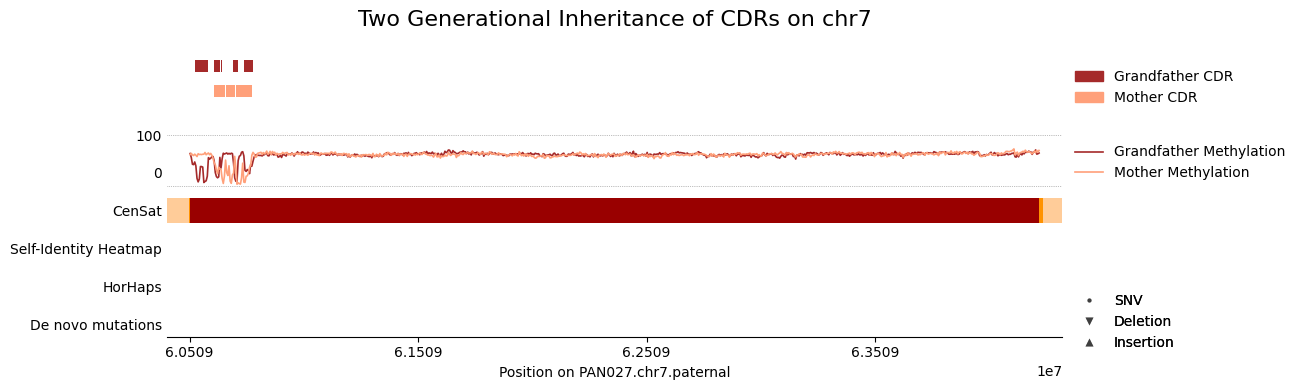

plotting PAN027 chrom - chr8/PAN027.chr8.maternal ...


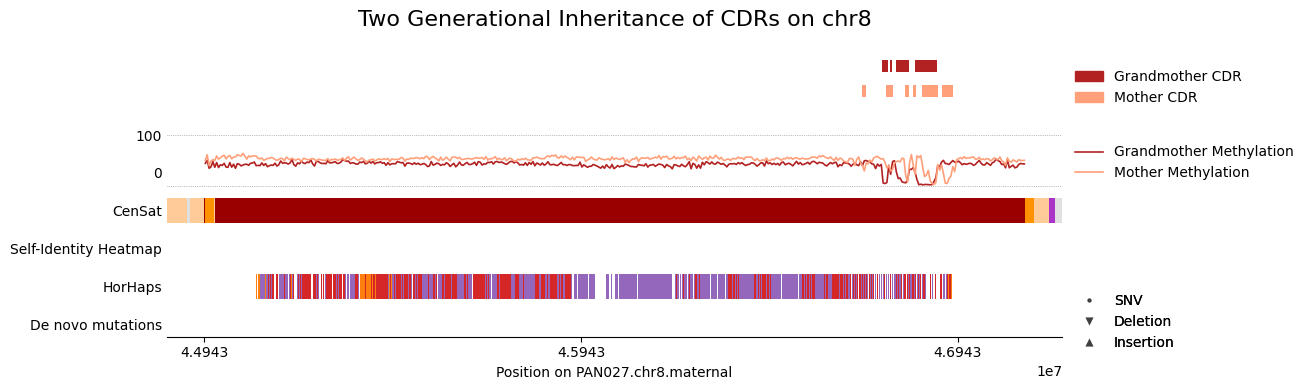

plotting PAN027 chrom - chr9/PAN027.chr9.maternal ...


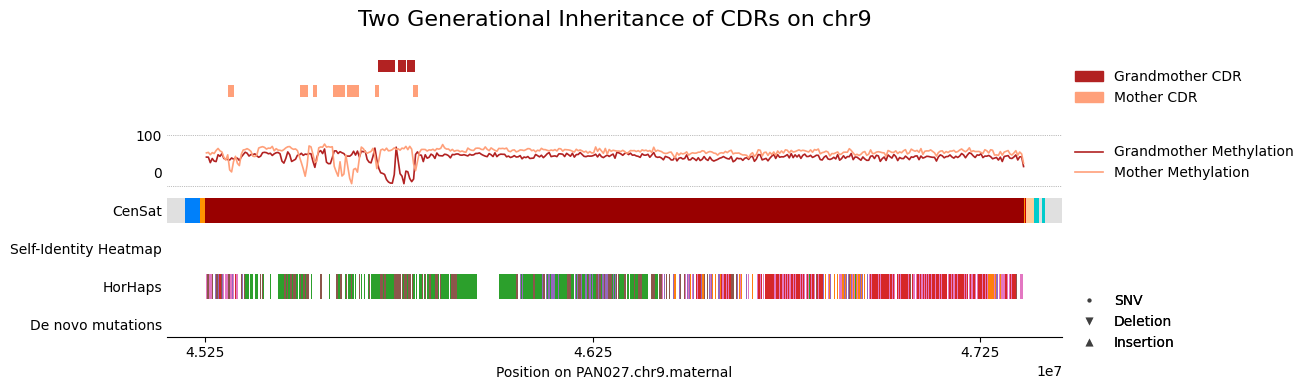

plotting PAN027 chrom - chr10/PAN027.chr10.paternal ...


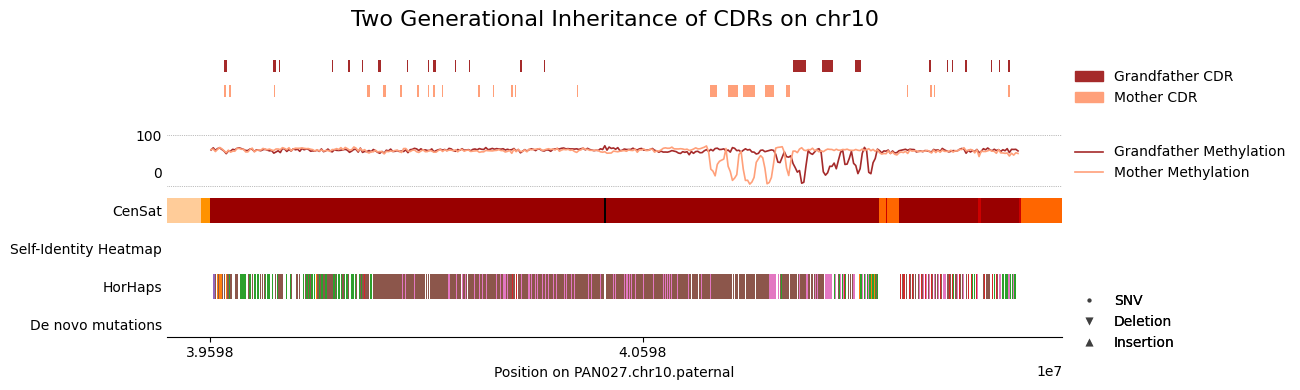

plotting PAN027 chrom - chr11/PAN027.chr11.maternal ...


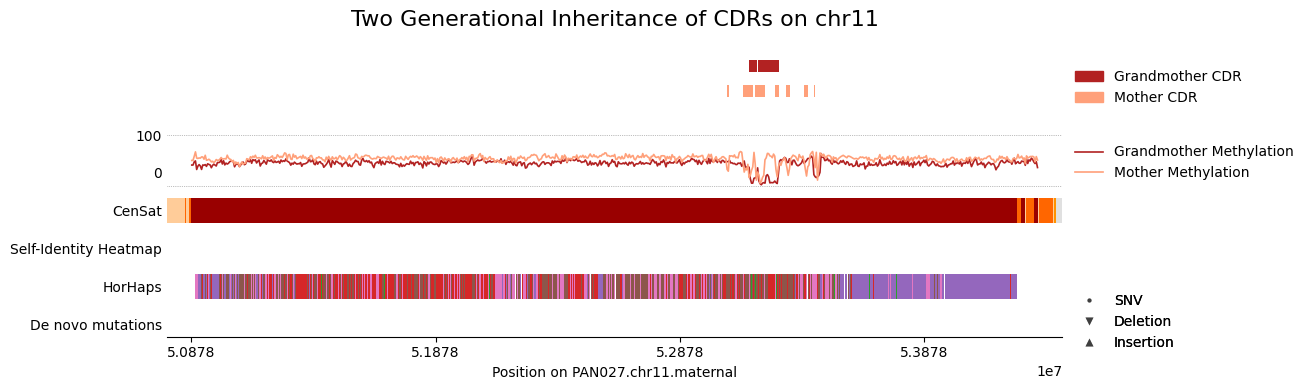

plotting PAN027 chrom - chr12/PAN027.chr12.maternal ...


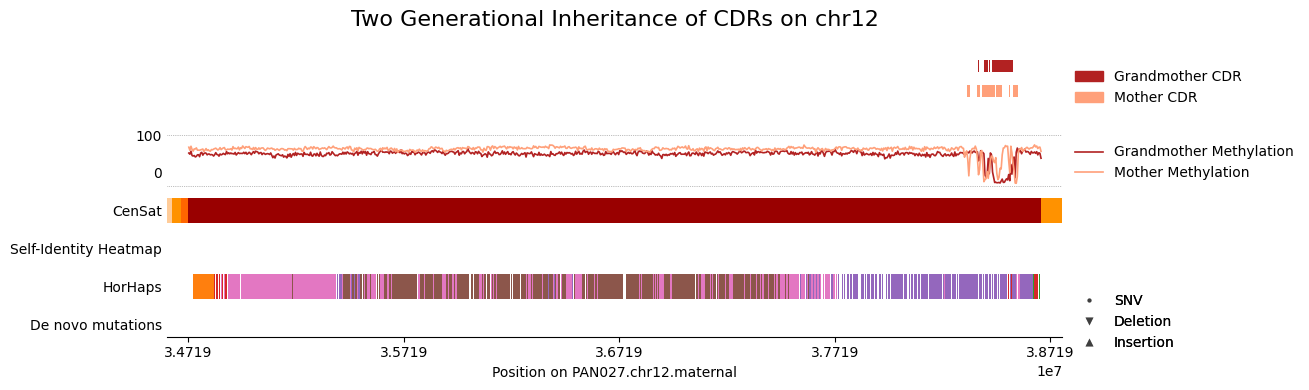

plotting PAN027 chrom - chr13/PAN027.chr13.paternal ...


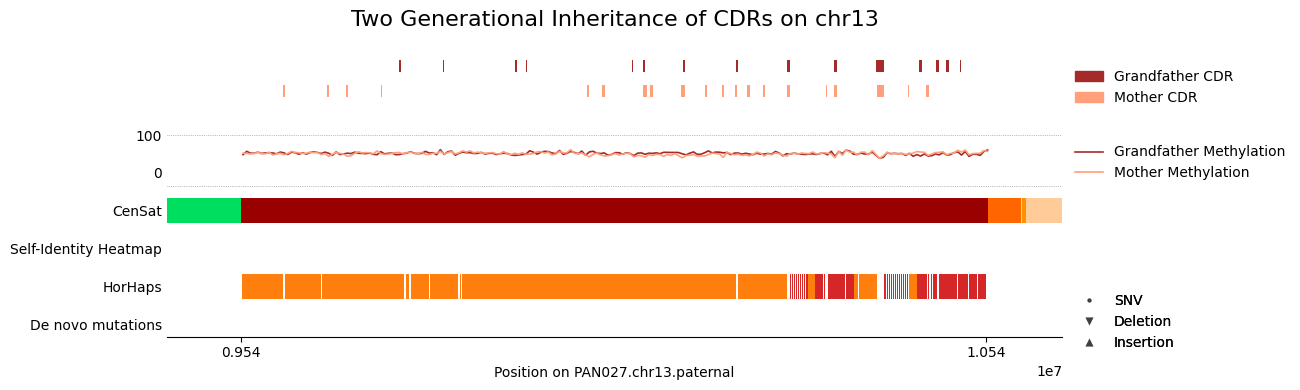

plotting PAN027 chrom - chr14/PAN027.chr14.maternal ...


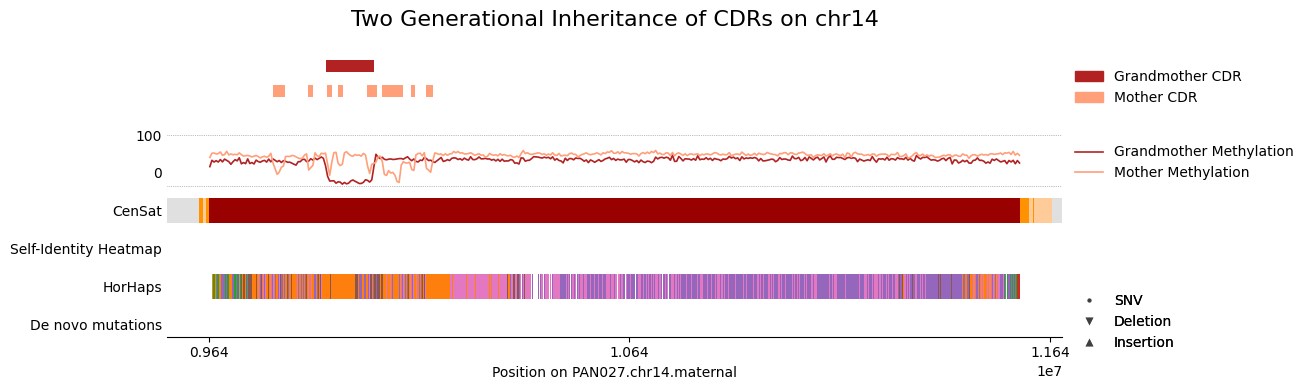

plotting PAN027 chrom - chr15/PAN027.chr15.maternal ...


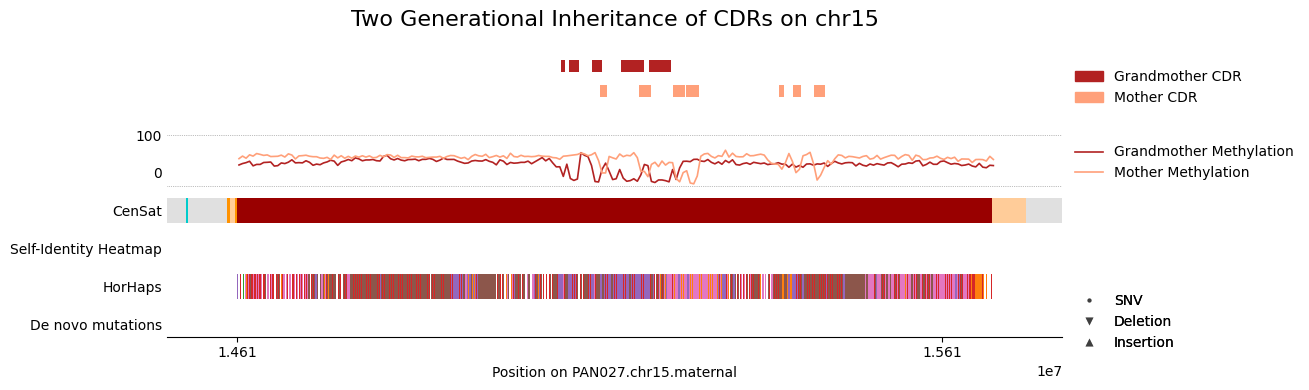

plotting PAN027 chrom - chr16/PAN027.chr16.maternal ...


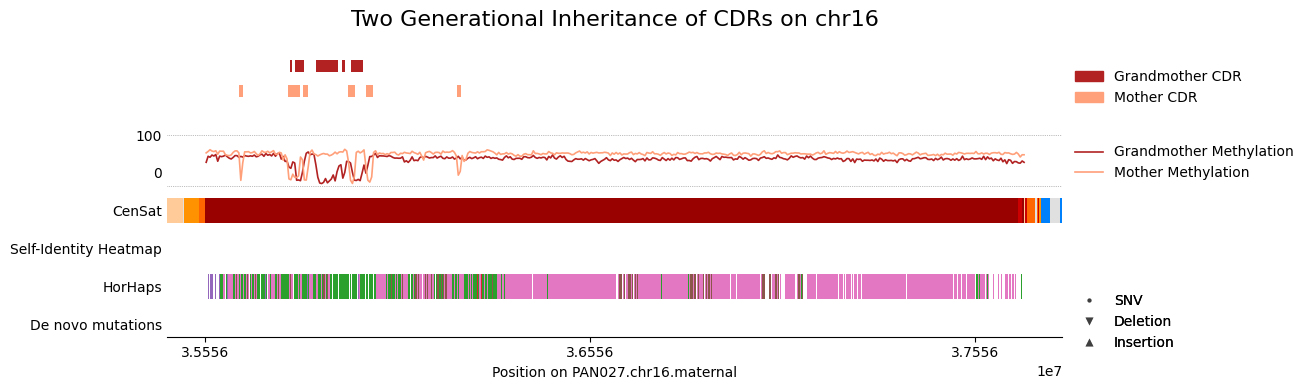

plotting PAN027 chrom - chr17/PAN027.chr17.paternal ...


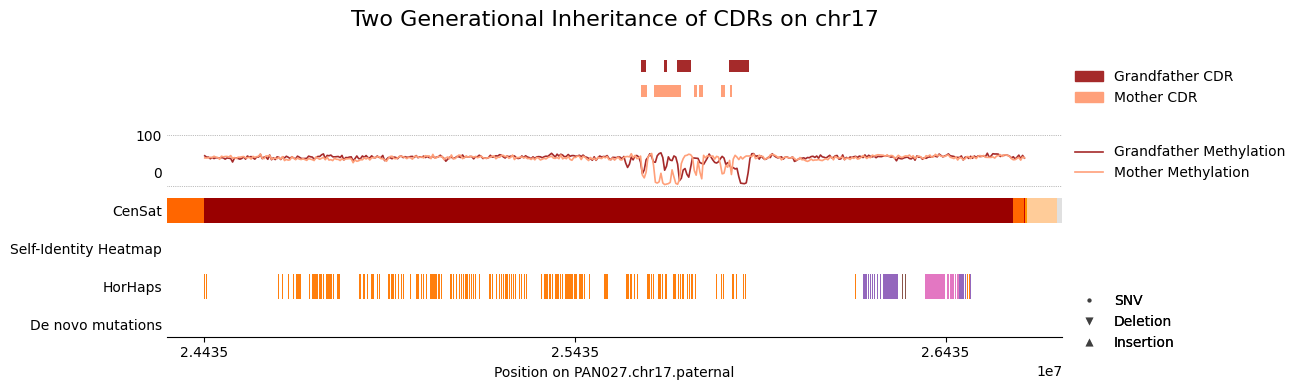

plotting PAN027 chrom - chr18/PAN027.chr18.paternal ...


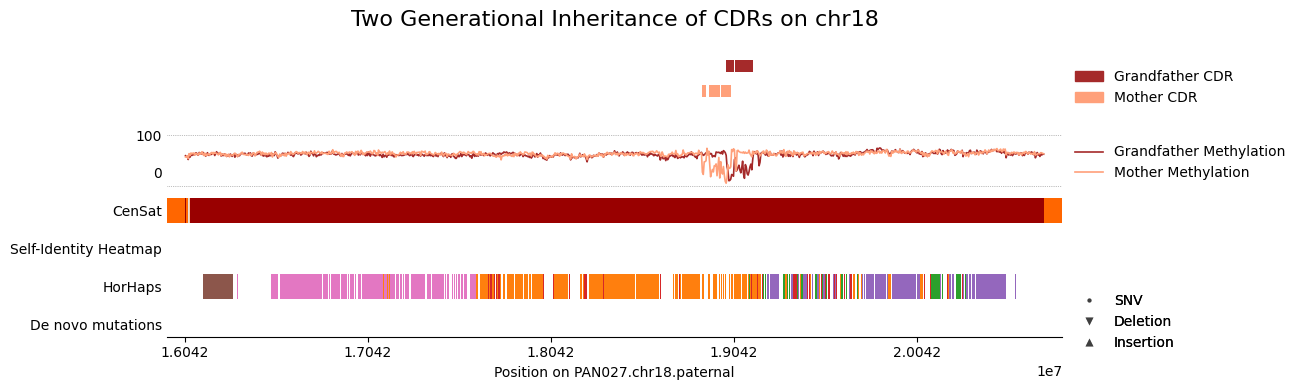

plotting PAN027 chrom - chr19/PAN027.chr19.maternal ...


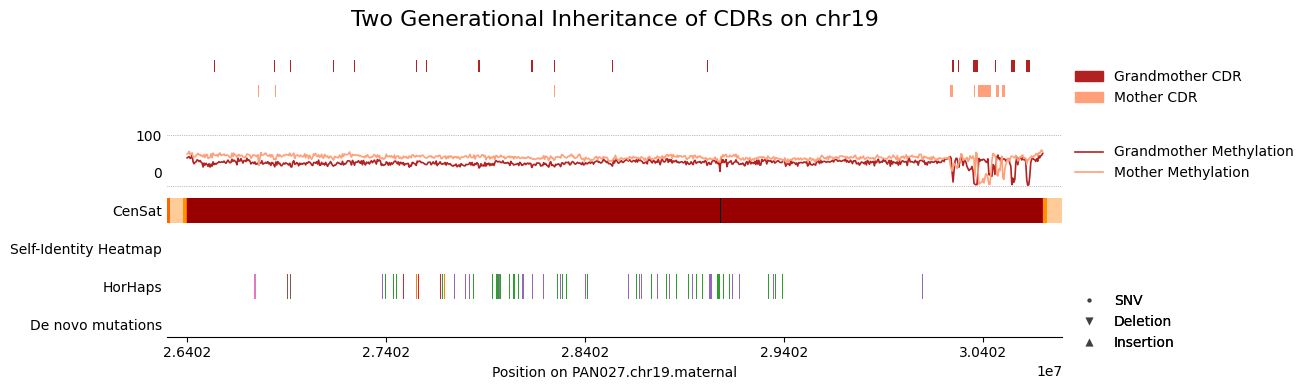

plotting PAN027 chrom - chr20/PAN027.chr20.paternal ...


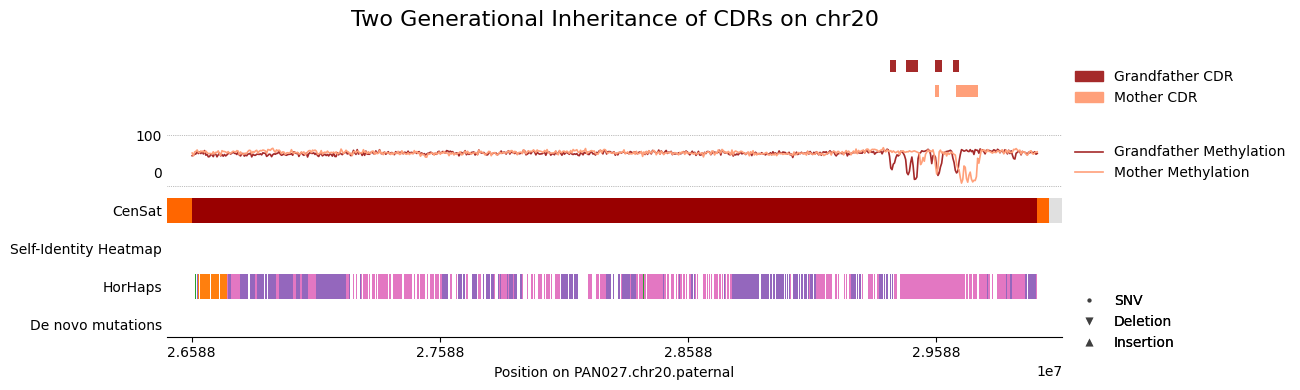

plotting PAN027 chrom - chr21/PAN027.chr21.maternal ...


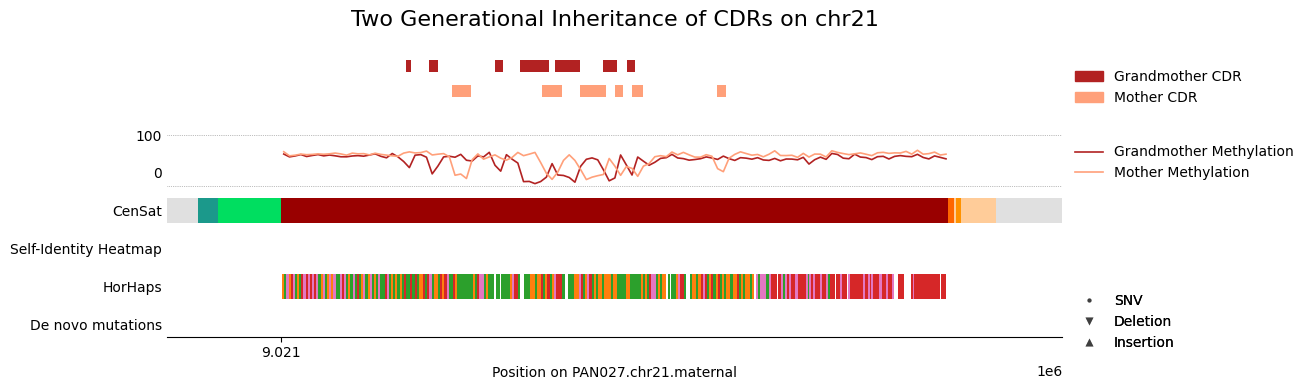

plotting PAN027 chrom - chr22/PAN027.chr22.maternal ...


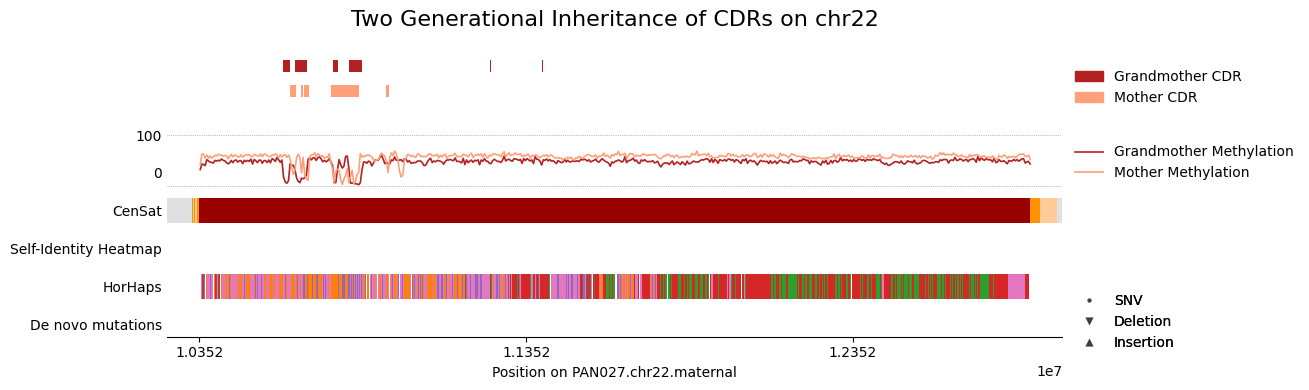

plotting PAN027 chrom - chrX/PAN027.chrX.paternal ...


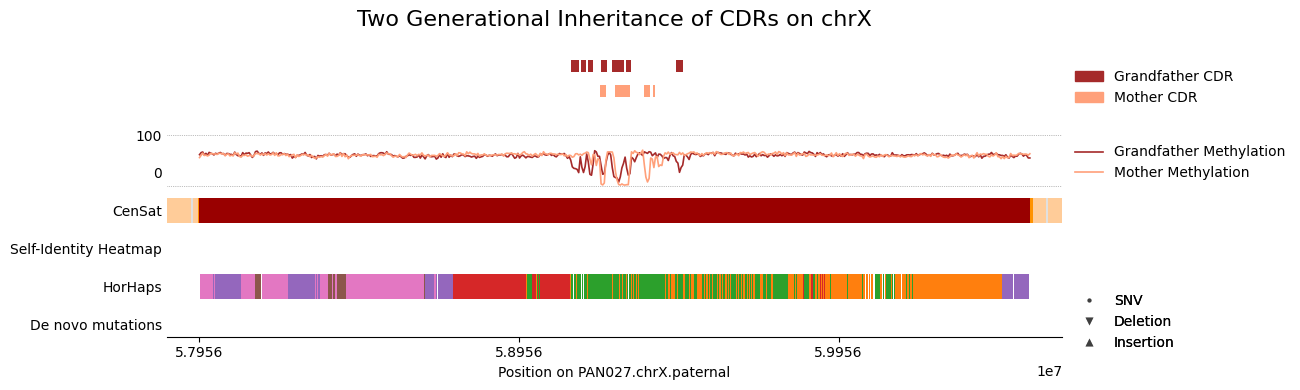

In [66]:
chroms = [f"chr{i}" for i in range(1, 23, 1)] + ["chrX"]

for c in chroms:
    plot_two_gen_cdr_inheritance( c )

# Make a merged `PAN027` CDR Prediction Dataset

In [ ]:
chroms = [f"chr{i}" for i in range(1, 23, 1)] + ["chrX"]
big_cdr = pd.DataFrame()

for c in chroms:
    all_matches = glob.glob(os.path.join(c, '**', '*'), recursive=True)
    PAN027_CDR_PATH = [f for f in all_matches if f.count('PAN027') == 2 and (f.count('maternal') == 2 or f.count('paternal') == 2) and f.endswith("centrodip.bed")]
    for path in PAN027_CDR_PATH:
        cur_cdr = pd.read_csv(path, sep="\t", header=None)
        big_cdr = pd.concat([big_cdr, cur_cdr], ignore_index=True)

big_cdr.to_csv("PAN027.centrodip.bed", header=None, index=None, sep='\t')